Data Description for this data set  

In this competition you will predict the speed at which a pet is adopted, based on the pet’s listing on PetFinder. Sometimes a profile represents a group of pets. In this case, the speed of adoption is determined by the speed at which all of the pets are adopted. The data included text, tabular, and image data. See below for details. 
This is a Kernels-only competition. At the end of the competition, test data will be replaced in their entirety with new data of approximately the same size, and your kernels will be rerun on the new data.



File descriptions
train.csv - Tabular/text data for the training set
test.csv - Tabular/text data for the test set
sample_submission.csv - A sample submission file in the correct format
breed_labels.csv - Contains Type, and BreedName for each BreedID. Type 1 is dog, 2 is cat.
color_labels.csv - Contains ColorName for each ColorID
state_labels.csv - Contains StateName for each StateID

Data Fields
PetID - Unique hash ID of pet profile

AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.

Type - Type of animal (1 = Dog, 2 = Cat)

Name - Name of pet (Empty if not named)

Age - Age of pet when listed, in months

Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)

Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)

Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)

Color1 - Color 1 of pet (Refer to ColorLabels dictionary)

Color2 - Color 2 of pet (Refer to ColorLabels dictionary)

Color3 - Color 3 of pet (Refer to ColorLabels dictionary)

MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)

Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)

Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)

Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

Quantity - Number of pets represented in profile

Fee - Adoption fee (0 = Free)

State - State location in Malaysia (Refer to StateLabels dictionary)

RescuerID - Unique hash ID of rescuer
VideoAmt - Total uploaded videos for this pet
PhotoAmt - Total uploaded photos for this pet
Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.

AdoptionSpeed (Target)
Contestants are required to predict this value. The value is determined by how quickly, if at all, a pet is adopted. The values are determined in the following way: 
0 - Pet was adopted on the same day as it was listed. 
1 - Pet was adopted between 1 and 7 days (1st week) after being listed. 
2 - Pet was adopted between 8 and 30 days (1st month) after being listed. 
3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed. 
4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [24]:
# Libraries to be imported for EDA 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Regression Models
from sklearn.naive_bayes import MultinomialNB
from featexp import get_univariate_plots
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
import missingno as msno
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib as mpl
mpl.use('TkAgg') # I added this line as a fix to a Matplotlib error - it couldn't be imported to the python environment
import matplotlib.pyplot as plt 
 
from scipy import stats
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [25]:
# Importing ignoring system warnings
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [26]:
# Importing the original Petfinders dataset
data_r = pd.read_csv('C:/Users/jlpar/Documents/Springboard Curriculum/Projects/Capsone Project Ideas/Capstone Data/Pet Adoption/train.csv')
print(type(data_r))

<class 'pandas.core.frame.DataFrame'>


In [27]:
# Quick dataframe Visualization
data_r.head(5)

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize      ...        Health  Quantity  Fee  State  \
0             1      ...             1         1  100  41326   
1             2      ...             1         1    0  41401   
2             2      ...             1         1    0  41326   
3             2      ...             1         1  150  41401   
4             2      ...             1         1    0  41326   

                          RescuerID  VideoAmt  \
0  8480853f516546f6cf33aa88cd76c379         0   
1  3082c7125d8fb66f7dd4bff4192c8b14         0   
2  fa90fa5b1ee11c86938398b60abc32cb         0   
3  9238e4f44c71a75282e62f7136c6b240         0   
4  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3      1.0   
1  I just found it alone yesterday near my apartm...  6296e909a      2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906      7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5      8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90      3.0   

   AdoptionSpeed  
0              2  
1              0  
2              3  
3              2  
4              2  

[5 rows x 24 columns]

In [28]:
## Importing and merging the breed, color and state files and the training and test files
breeds = pd.read_csv('C:/Users/jlpar/Documents/Springboard Curriculum/Data/petadoption/petfinder-adoption-prediction/breed_labels.csv')
colors = pd.read_csv('C:/Users/jlpar/Documents/Springboard Curriculum/Data/petadoption/petfinder-adoption-prediction/color_labels.csv')
states = pd.read_csv('C:/Users/jlpar/Documents/Springboard Curriculum/Data/petadoption/petfinder-adoption-prediction/state_labels.csv')

train = pd.read_csv('C:/Users/jlpar/Documents/Springboard Curriculum/Data/petadoption/petfinder-adoption-prediction/train.csv')
test = pd.read_csv('C:/Users/jlpar/Documents/Springboard Curriculum/Data/petadoption/petfinder-adoption-prediction/test.csv')
sub = pd.read_csv('C:/Users/jlpar/Documents/Springboard Curriculum/Data/petadoption/petfinder-adoption-prediction/sample_submission.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])

In [29]:
## Dataframe view of all combined data
all_data.head(3)

AdoptionSpeed  Age  Breed1  Breed2  Color1  Color2  Color3  \
0            2.0    3     299       0       1       7       0   
1            0.0    1     265       0       1       2       0   
2            3.0    1     307       0       2       7       0   

                                         Description  Dewormed  Fee  \
0  Nibble is a 3+ month old ball of cuteness. He ...         2  100   
1  I just found it alone yesterday near my apartm...         3    0   
2  Their pregnant mother was dumped by her irresp...         1    0   

       ...           PetID  PhotoAmt  Quantity  \
0      ...       86e1089a3       1.0         1   
1      ...       6296e909a       2.0         1   
2      ...       3422e4906       7.0         1   

                          RescuerID  State Sterilized  Type  Vaccinated  \
0  8480853f516546f6cf33aa88cd76c379  41326          2     2           2   
1  3082c7125d8fb66f7dd4bff4192c8b14  41401          3     2           3   
2  fa90fa5b1ee11c86938398b60abc32cb  41326          2     1           1   

  VideoAmt  dataset_type  
0        0         train  
1        0         train  
2        0         train  

[3 rows x 25 columns]

In [30]:
# Looking at the names of the columns
data_r.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [31]:
# Shape of the rows and columns for the raw training dataset 
nrow, ncol = data_r.shape
nrow, ncol

(14993, 24)

In [32]:
## Dataframe view for training dataset only
data_r.describe(include='all')

Type   Name           Age        Breed1        Breed2  \
count   14993.000000  13736  14993.000000  14993.000000  14993.000000   
unique           NaN   9060           NaN           NaN           NaN   
top              NaN   Baby           NaN           NaN           NaN   
freq             NaN     66           NaN           NaN           NaN   
mean        1.457614    NaN     10.452078    265.272594     74.009738   
std         0.498217    NaN     18.155790     60.056818    123.011575   
min         1.000000    NaN      0.000000      0.000000      0.000000   
25%         1.000000    NaN      2.000000    265.000000      0.000000   
50%         1.000000    NaN      3.000000    266.000000      0.000000   
75%         2.000000    NaN     12.000000    307.000000    179.000000   
max         2.000000    NaN    255.000000    307.000000    307.000000   

              Gender        Color1        Color2        Color3  MaturitySize  \
count   14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
unique           NaN           NaN           NaN           NaN           NaN   
top              NaN           NaN           NaN           NaN           NaN   
freq             NaN           NaN           NaN           NaN           NaN   
mean        1.776162      2.234176      3.222837      1.882012      1.862002   
std         0.681592      1.745225      2.742562      2.984086      0.547959   
min         1.000000      1.000000      0.000000      0.000000      1.000000   
25%         1.000000      1.000000      0.000000      0.000000      2.000000   
50%         2.000000      2.000000      2.000000      0.000000      2.000000   
75%         2.000000      3.000000      6.000000      5.000000      2.000000   
max         3.000000      7.000000      7.000000      7.000000      4.000000   

            ...              Health      Quantity           Fee         State  \
count       ...        14993.000000  14993.000000  14993.000000  14993.000000   
unique      ...                 NaN           NaN           NaN           NaN   
top         ...                 NaN           NaN           NaN           NaN   
freq        ...                 NaN           NaN           NaN           NaN   
mean        ...            1.036617      1.576069     21.259988  41346.028347   
std         ...            0.199535      1.472477     78.414548     32.444153   
min         ...            1.000000      1.000000      0.000000  41324.000000   
25%         ...            1.000000      1.000000      0.000000  41326.000000   
50%         ...            1.000000      1.000000      0.000000  41326.000000   
75%         ...            1.000000      1.000000      0.000000  41401.000000   
max         ...            3.000000     20.000000   3000.000000  41415.000000   

                               RescuerID      VideoAmt   Description  \
count                              14993  14993.000000         14981   
unique                              5595           NaN         14032   
top     fa90fa5b1ee11c86938398b60abc32cb           NaN  For Adoption   
freq                                 459           NaN           164   
mean                                 NaN      0.056760           NaN   
std                                  NaN      0.346185           NaN   
min                                  NaN      0.000000           NaN   
25%                                  NaN      0.000000           NaN   
50%                                  NaN      0.000000           NaN   
75%                                  NaN      0.000000           NaN   
max                                  NaN      8.000000           NaN   

            PetID      PhotoAmt  AdoptionSpeed  
count       14993  14993.000000   14993.000000  
unique      14993           NaN            NaN  
top     a6c985a00           NaN            NaN  
freq            1           NaN            NaN  
mean          NaN      3.889215       2.516441  
std           NaN      3.487810       1.177265

In [33]:
# Information for the raw dataset 
data_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

In [34]:
## Importing and running pandas profile statement
import pandas_profiling
pandas_profiling.ProfileReport(data_r)

In [35]:
## Exporting Pandas Profile

profile = pandas_profiling.ProfileReport(data_r)
profile.to_file(outputfile="Downloads/report.html")

                                            Plots for Type                                            


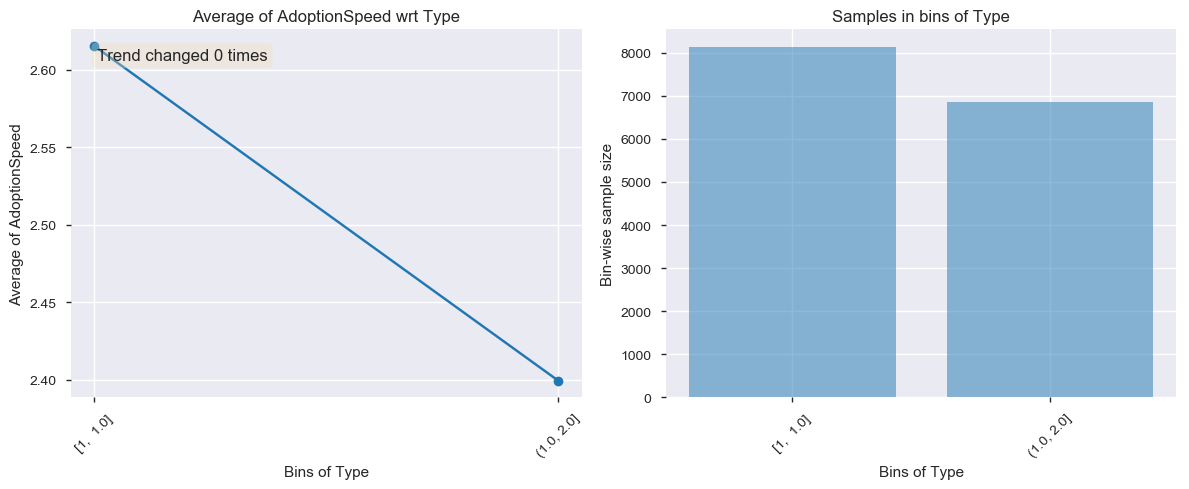

--------------------------------------------------------------------------------------------------------------


                                            Plots for Age                                             


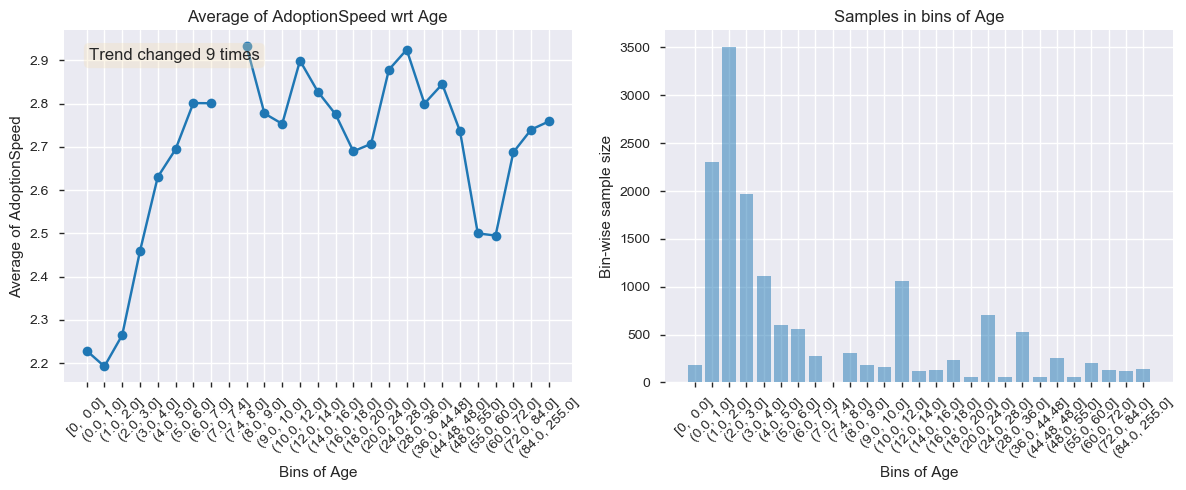

--------------------------------------------------------------------------------------------------------------


                                           Plots for Breed1                                           


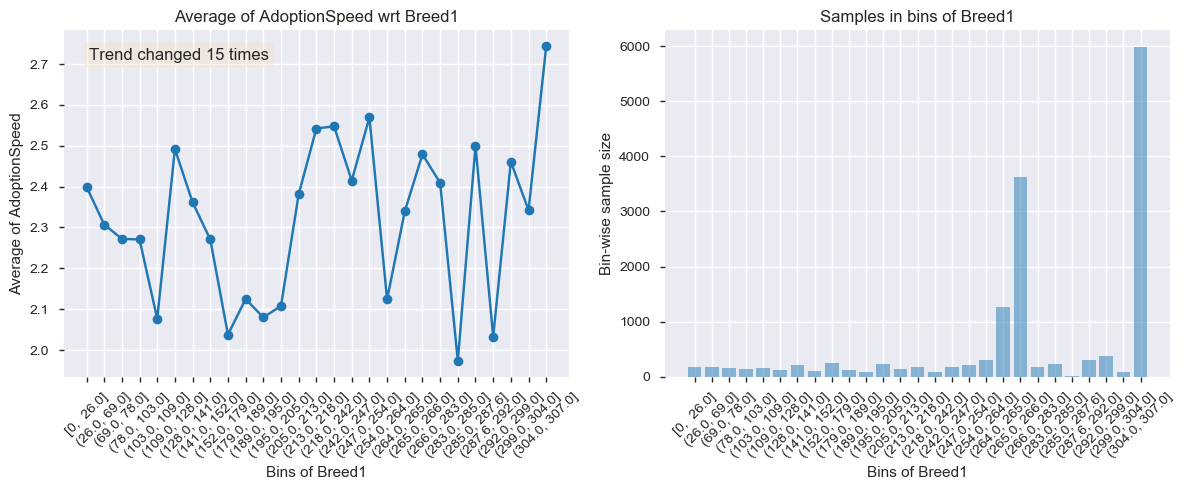

--------------------------------------------------------------------------------------------------------------


                                           Plots for Breed2                                           


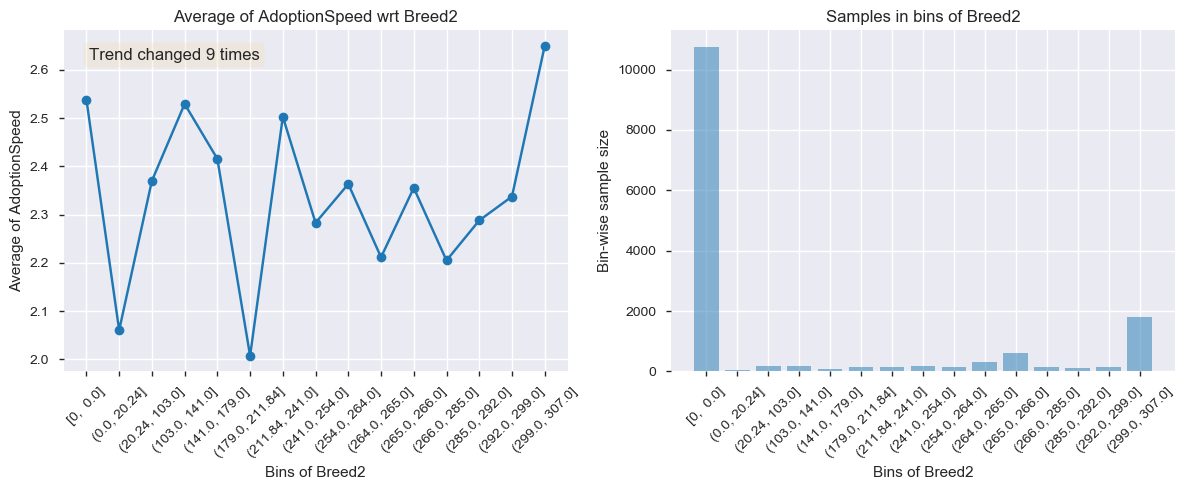

--------------------------------------------------------------------------------------------------------------


                                           Plots for Gender                                           


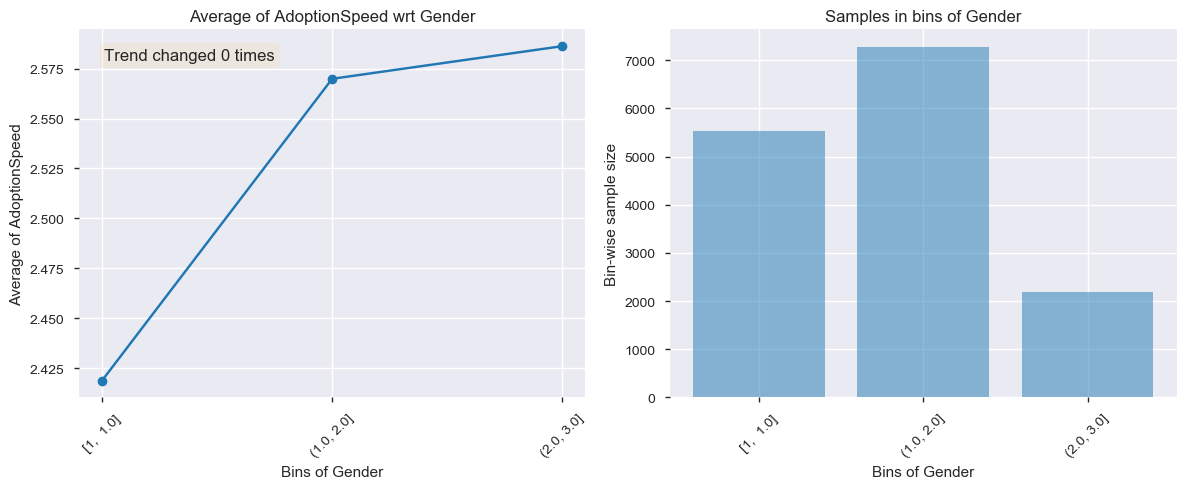

--------------------------------------------------------------------------------------------------------------


                                           Plots for Color1                                           


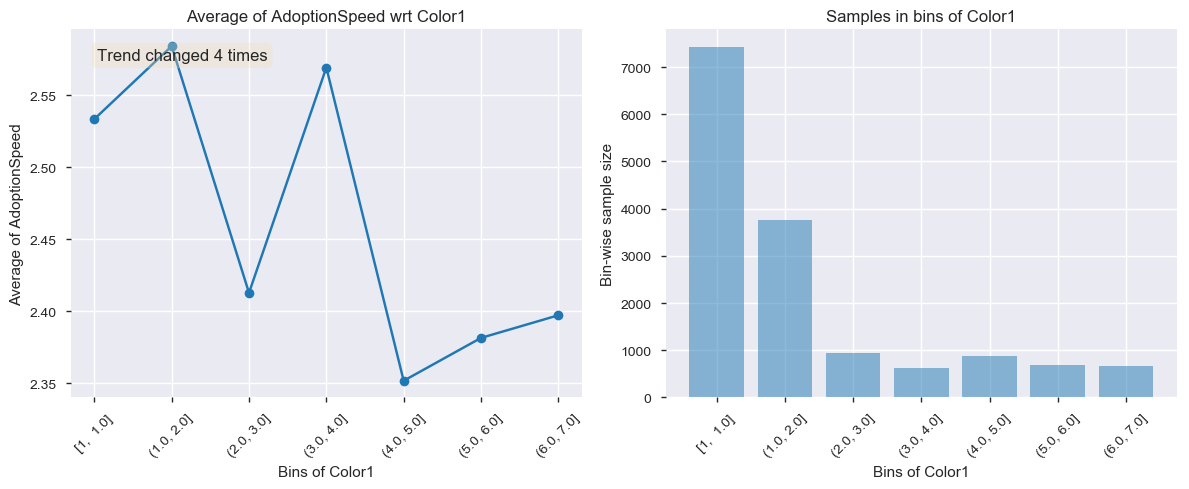

--------------------------------------------------------------------------------------------------------------


                                           Plots for Color2                                           


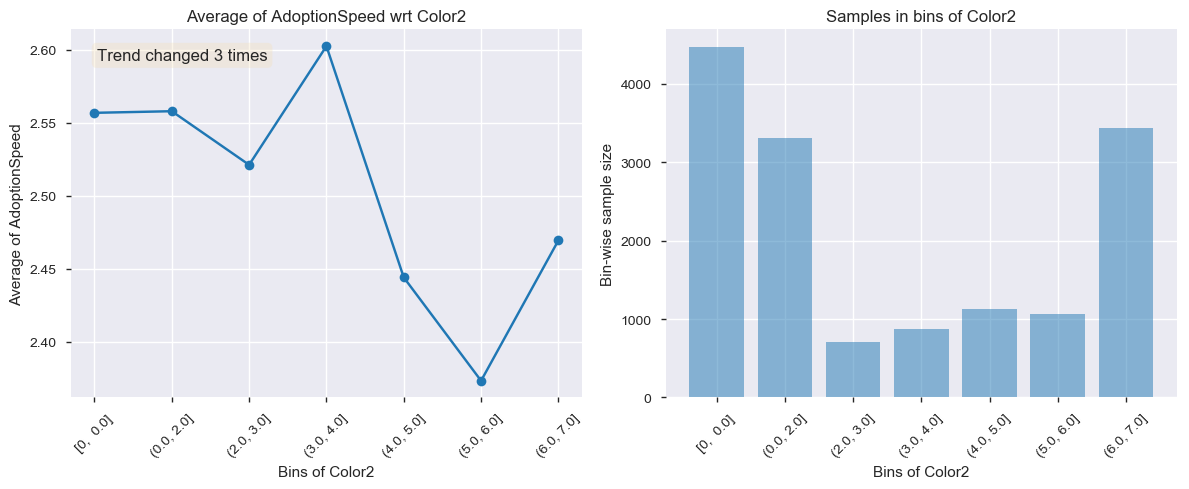

--------------------------------------------------------------------------------------------------------------


                                           Plots for Color3                                           


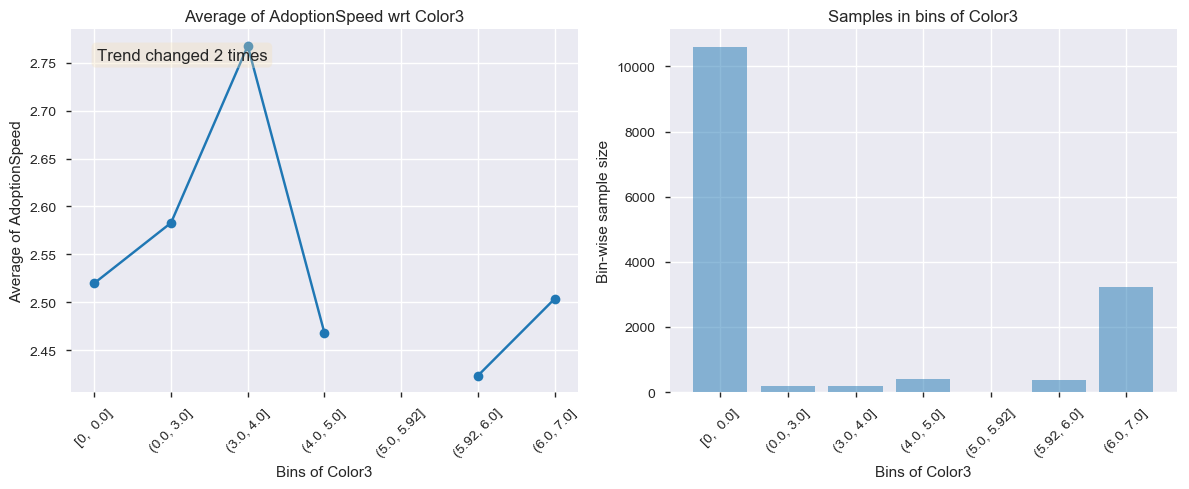

--------------------------------------------------------------------------------------------------------------


                                        Plots for MaturitySize                                        


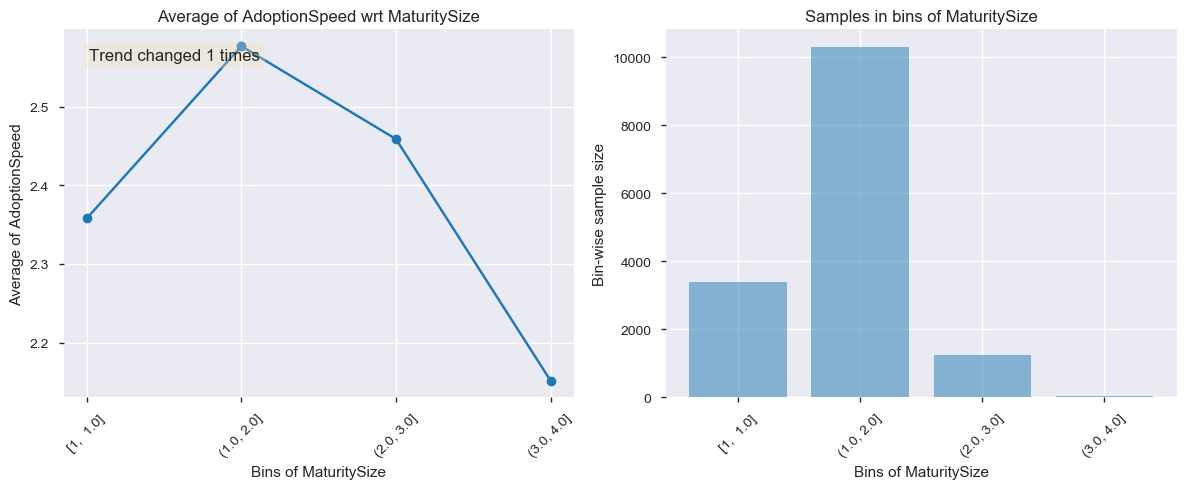

--------------------------------------------------------------------------------------------------------------


                                         Plots for FurLength                                          


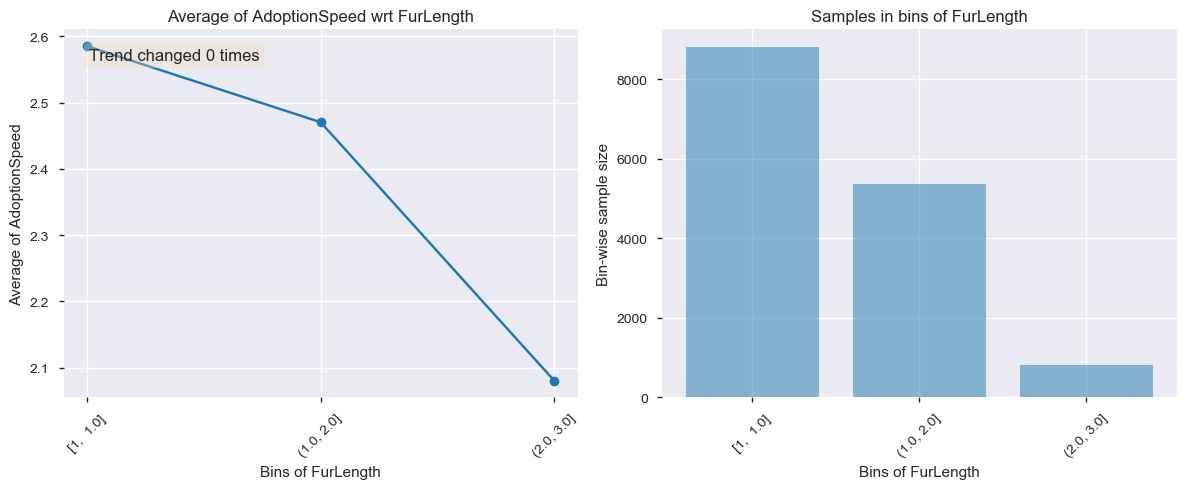

--------------------------------------------------------------------------------------------------------------


                                         Plots for Vaccinated                                         


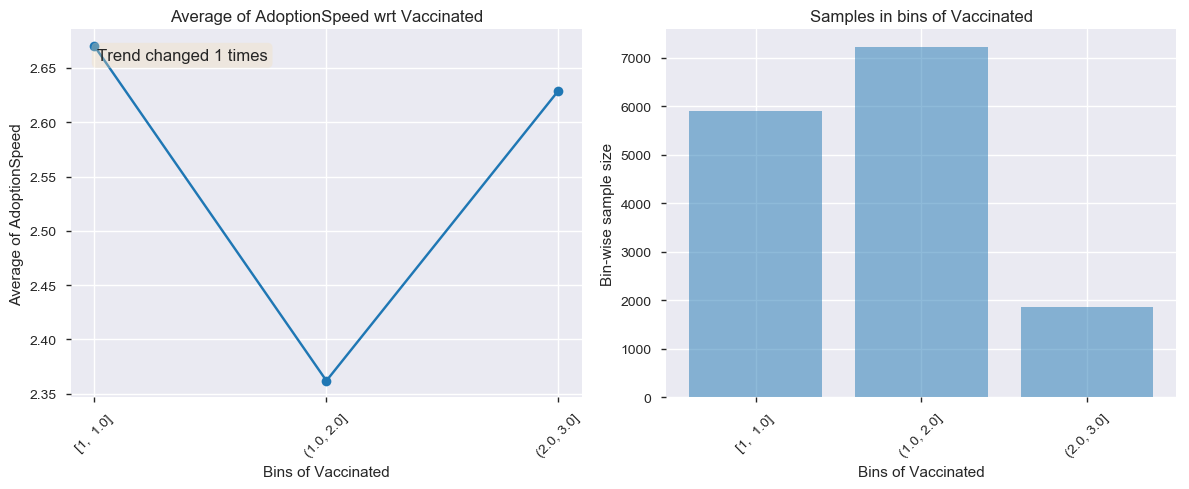

--------------------------------------------------------------------------------------------------------------


                                          Plots for Dewormed                                          


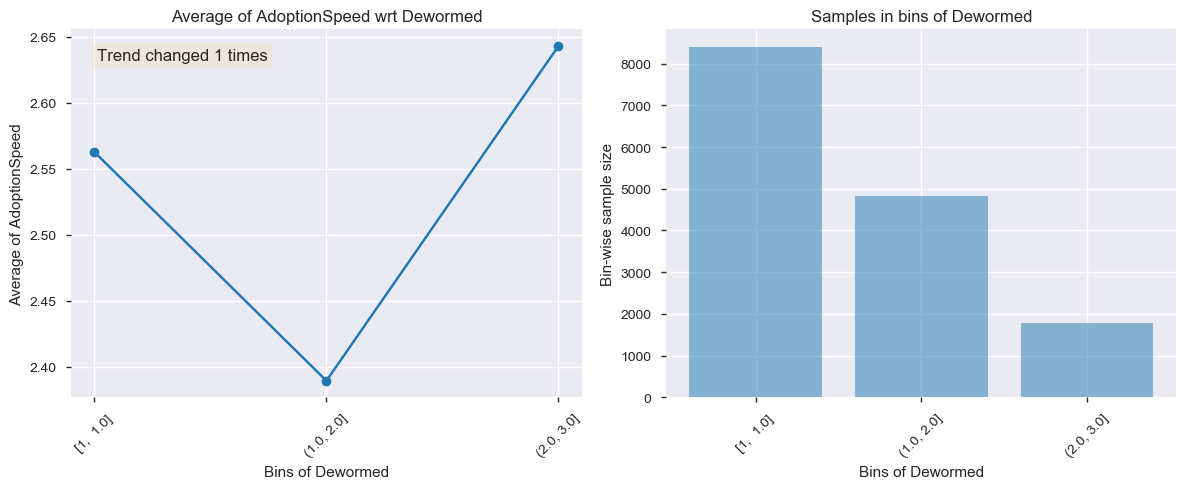

--------------------------------------------------------------------------------------------------------------


                                         Plots for Sterilized                                         


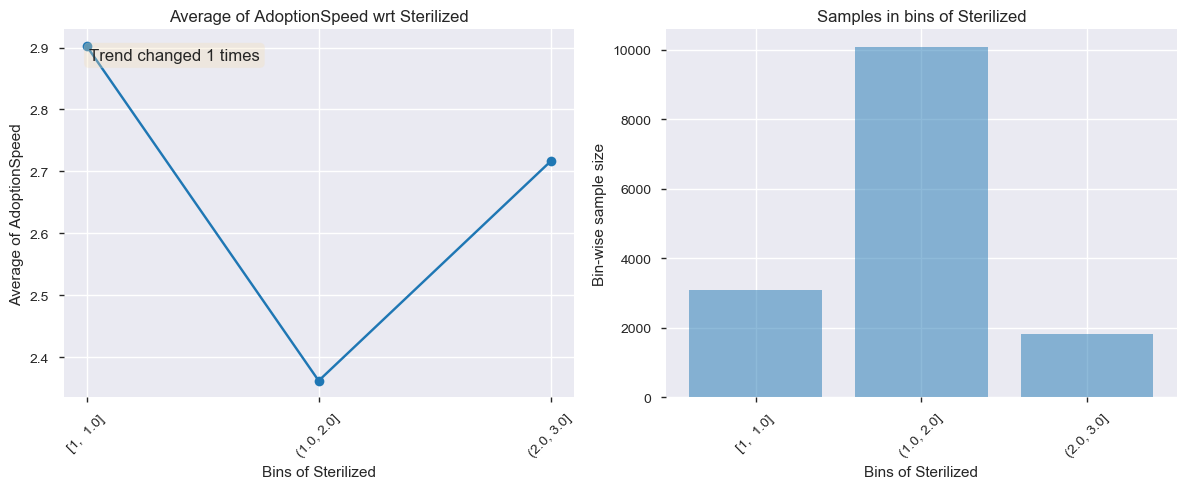

--------------------------------------------------------------------------------------------------------------


                                           Plots for Health                                           


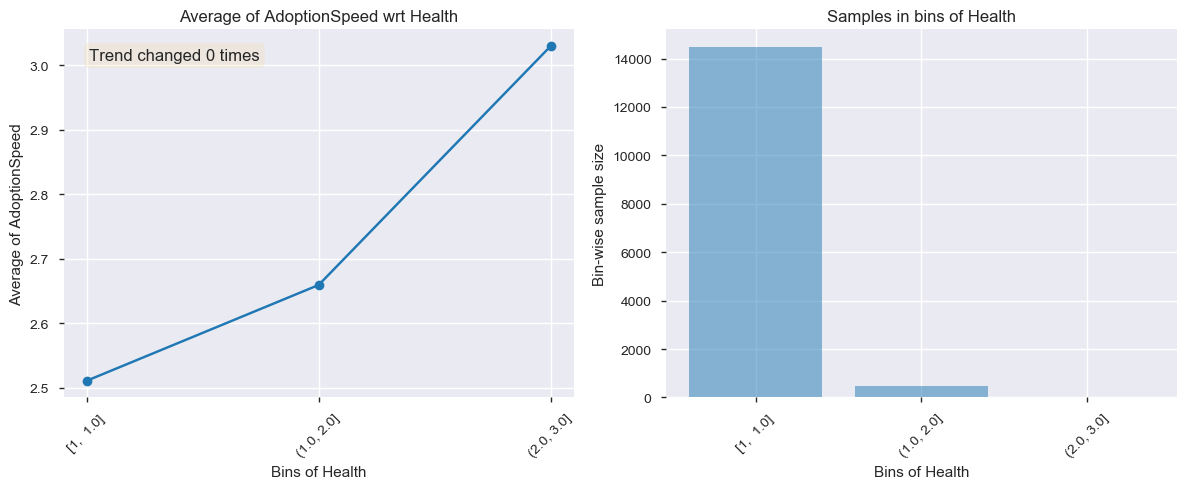

--------------------------------------------------------------------------------------------------------------


                                          Plots for Quantity                                          


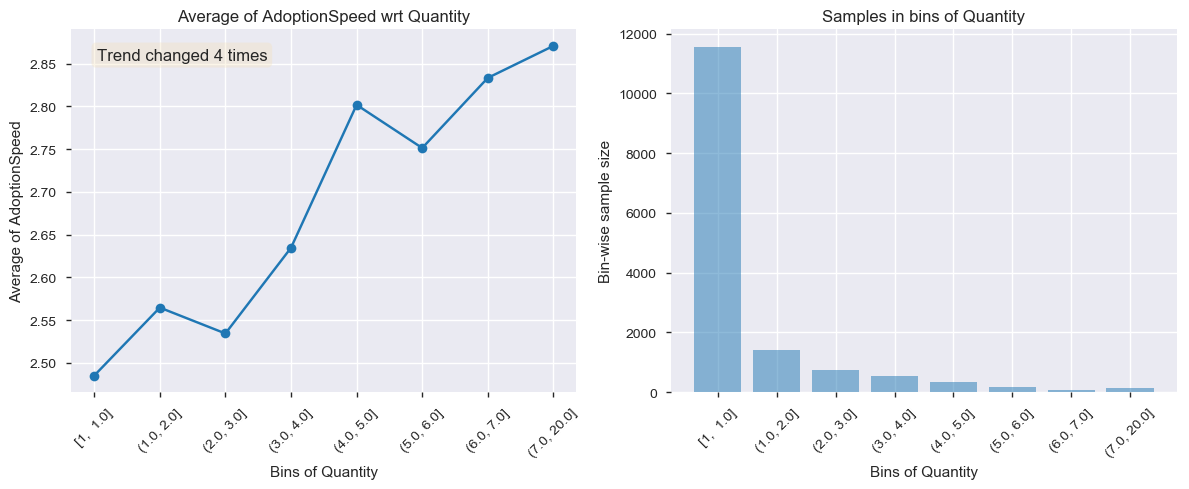

--------------------------------------------------------------------------------------------------------------


                                            Plots for Fee                                             


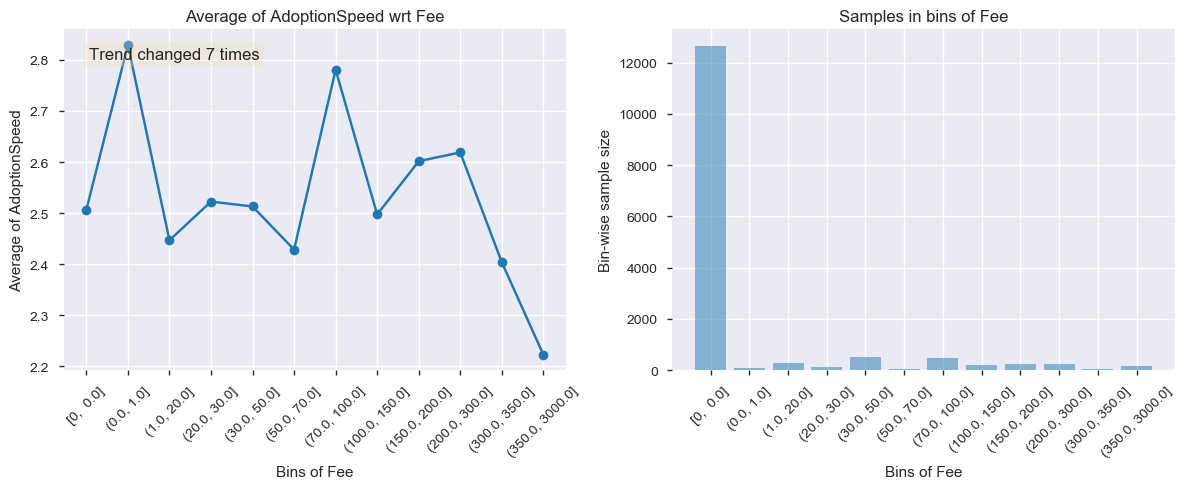

--------------------------------------------------------------------------------------------------------------


                                           Plots for State                                            


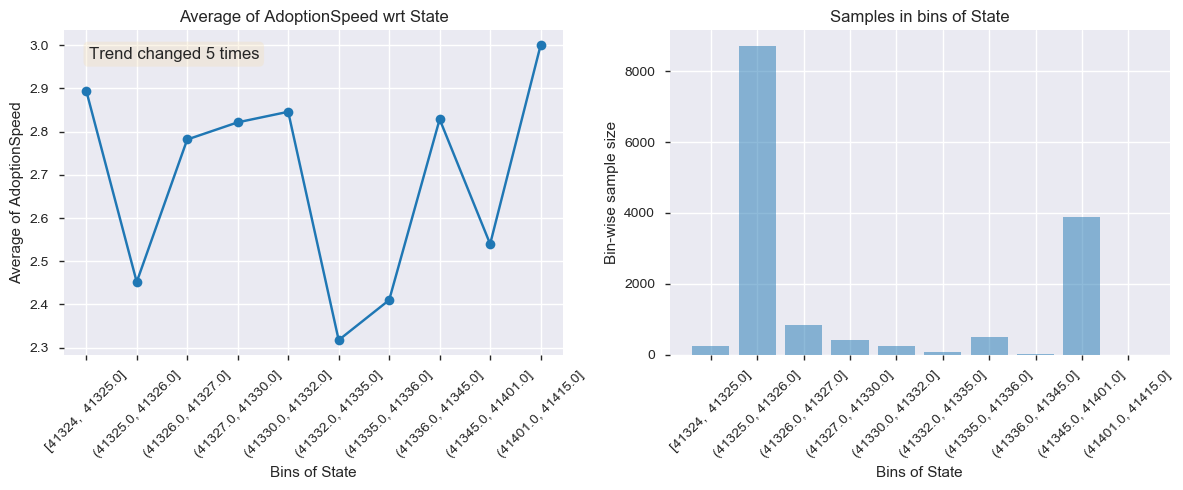

--------------------------------------------------------------------------------------------------------------




In [36]:
# Plots drawn for all features if nothing is passed in feature_list parameter.

get_univariate_plots(data=data_r, target_col='AdoptionSpeed', 
                     features_list=['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State'], bins=100)

In [37]:
# looking for missing and unique data from the raw training dataset  
data_r_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss'])
tmp = pd.DataFrame()

for c in data_r.columns:
    tmp['column'] = [c]
    tmp['values'] = [data_r[c].unique()]
    tmp['values_count_incna'] = len(list(data_r[c].unique()))
    tmp['values_count_nona'] = int(data_r[c].nunique())
    tmp['num_miss'] = data_r[c].isnull().sum()
    tmp['pct_miss'] = (data_r[c].isnull().sum()/ len(data_r)).round(3)*100
    data_r_stats = data_r_stats.append(tmp)

In [38]:
# Ascending sort on the Numboer of Distinct Categories for each categorical Variables
data_r_stats.sort_values(by = 'values_count_incna', inplace = True, ascending = True)

# And set the index to Column Names
data_r_stats.set_index('column', inplace = True)
data_r_stats 

values  \
column                                                             
Type                                                      [2, 1]   
Health                                                 [1, 2, 3]   
Sterilized                                             [2, 3, 1]   
Dewormed                                               [2, 3, 1]   
FurLength                                              [1, 2, 3]   
Vaccinated                                             [2, 3, 1]   
Gender                                                 [1, 2, 3]   
MaturitySize                                        [1, 2, 3, 4]   
AdoptionSpeed                                    [2, 0, 3, 1, 4]   
Color3                                        [0, 7, 5, 6, 4, 3]   
Color1                                     [1, 2, 5, 6, 3, 7, 4]   
Color2                                     [7, 2, 0, 6, 5, 4, 3]   
VideoAmt                             [0, 1, 3, 4, 2, 6, 5, 7, 8]   
State          [41326, 41401, 41330, 41327, 41361, 41336, 413...   
Quantity       [1, 6, 7, 5, 3, 10, 2, 9, 4, 8, 20, 18, 12, 11...   
PhotoAmt       [1.0, 2.0, 7.0, 8.0, 3.0, 9.0, 6.0, 5.0, 0.0, ...   
Fee            [100, 0, 150, 300, 50, 10, 1, 30, 750, 400, 80...   
Age            [3, 1, 4, 12, 0, 2, 78, 6, 8, 10, 36, 14, 24, ...   
Breed2         [0, 264, 205, 307, 117, 251, 265, 218, 292, 26...   
Breed1         [299, 265, 307, 266, 264, 218, 114, 285, 189, ...   
RescuerID      [8480853f516546f6cf33aa88cd76c379, 3082c7125d8...   
Name           [Nibble, No Name Yet, Brisco, Miko, Hunter, na...   
Description    [Nibble is a 3+ month old ball of cuteness. He...   
PetID          [86e1089a3, 6296e909a, 3422e4906, 5842f1ff5, 8...   

              values_count_incna values_count_nona num_miss  pct_miss  
column                                                                 
Type                           2                 2        0       0.0  
Health                         3                 3        0       0.0  
Sterilized                     3                 3        0       0.0  
Dewormed                       3                 3        0       0.0  
FurLength                      3                 3        0       0.0  
Vaccinated                     3                 3        0       0.0  
Gender                         3                 3        0       0.0  
MaturitySize                   4                 4        0       0.0  
AdoptionSpeed                  5                 5        0       0.0  
Color3                         6                 6        0       0.0  
Color1                         7                 7        0       0.0  
Color2                         7                 7        0       0.0  
VideoAmt                       9                 9        0       0.0  
State                         14                14        0       0.0  
Quantity                      19                19        0       0.0  
PhotoAmt                      31                31        0       0.0  
Fee                           74                74        0       0.0  
Age                          106               106        0       0.0  
Breed2                       135               135        0       0.0  
Breed1                       176               176        0       0.0  
RescuerID                   5595              5595        0       0.0  
Name                        9061              9060     1257       8.4  
Description                14033             14032       12       0.1  
PetID                      14993             14993        0       0.0

In [39]:
# Total missing values for each feature
print(data_r.isnull().sum())

Type                0
Name             1257
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        12
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64


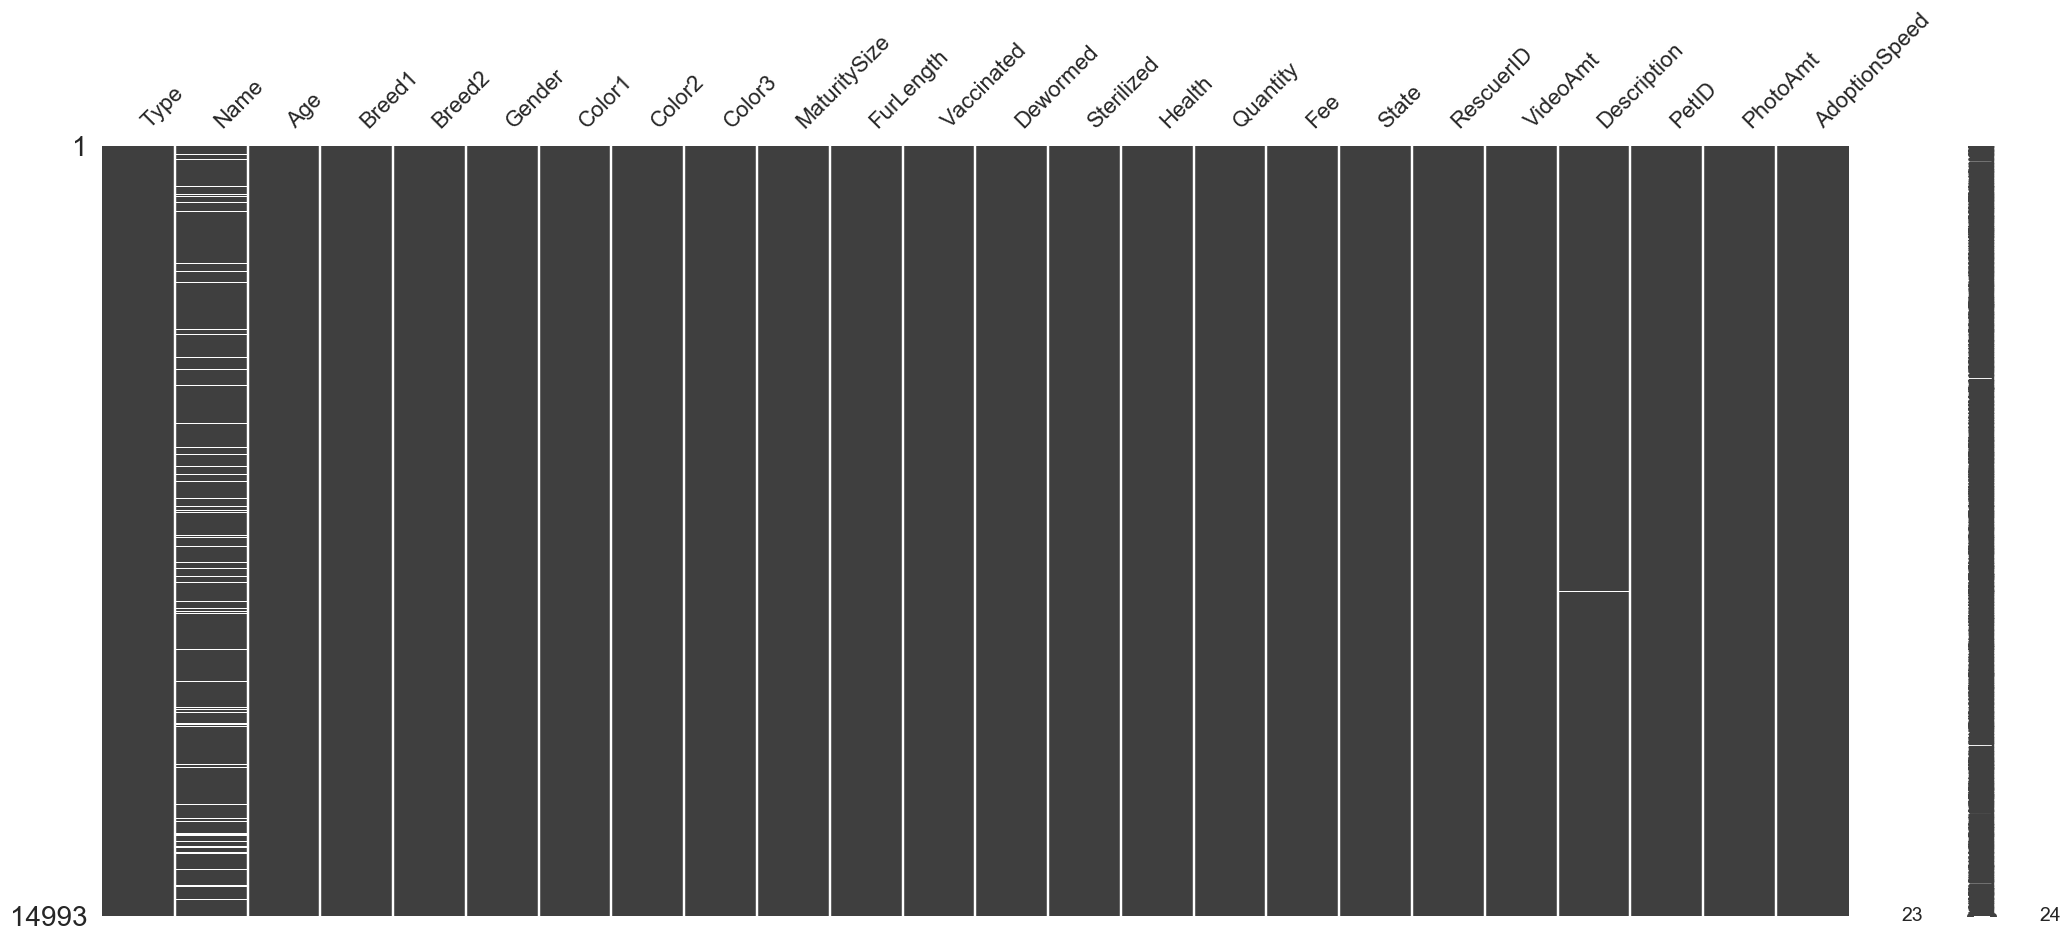

In [40]:
## Missing Value Matrix displaying the distribution of the missing values
msno.matrix(data_r)
plt.show()

In [41]:
## Dropping the non numerical data from the raw data set
data_r2 = data_r.drop(['Name','Description','PetID','PhotoAmt','VideoAmt','RescuerID'],  axis=1)
data_r2.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'AdoptionSpeed'],
      dtype='object')

In [42]:
############# Univariate Analysis########################################## 

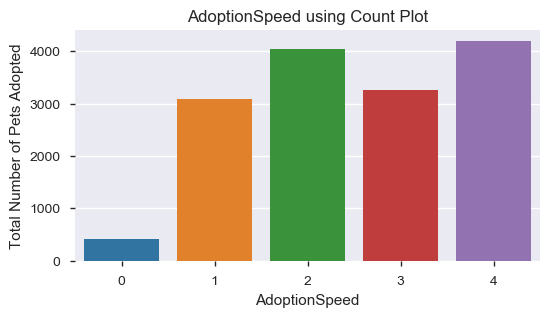

In [43]:
## Creating a Count Plot for AdoptionSpeed
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('AdoptionSpeed', data=data_r2)
ax.set_title('AdoptionSpeed using Count Plot')
ax.set_xlabel('AdoptionSpeed')
ax.set_ylabel('Total Number of Pets Adopted')

plt.show()

In [44]:
## Creating a Bar Chart and Inferential Statistics for an individual attribute
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()

count    14993.000000
mean         2.516441
std          1.177265
min          0.000000
25%          2.000000
50%          2.000000
75%          4.000000
max          4.000000
Name: AdoptionSpeed, dtype: float64
mode:  0    4
dtype: int64
4    4197
2    4037
3    3259
1    3090
0     410
Name: AdoptionSpeed, dtype: int64


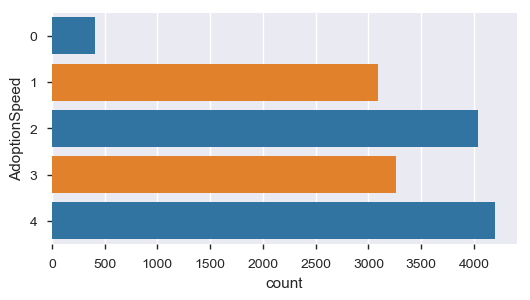

In [45]:
# Target Variable: AdoptionSpeed
count, ax = plt.subplots(figsize=(6,3))
c_palette = ['tab:blue', 'tab:orange']
categorical_summarized(data_r2, y = 'AdoptionSpeed', palette=c_palette)
plt.show()

sep = pd.read_csv('C:/Users/jlpar/Documents/Springboard Curriculum/Data/petadoption/petfinder-adoption-prediction/05octdata_r2.csv')
sep.head(3)

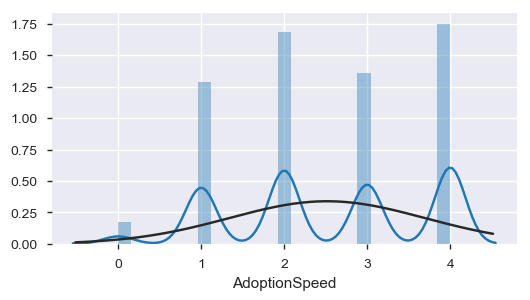

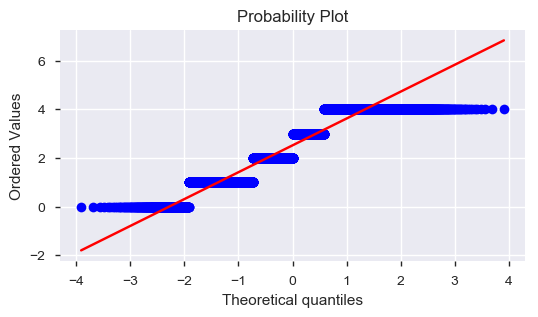

In [46]:
#histogram and normal probability plot for AdoptionSpeed
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(data_r2['AdoptionSpeed'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(data_r['AdoptionSpeed'], plot=plt)

In [47]:
## Creating Binned AdoptionSpeed Column
data_r2["AdoptionSpeed_t"]=data_r2["AdoptionSpeed"]
data_r.head(1)

Type    Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2  Nibble    3     299       0       1       1       7       0   

   MaturitySize      ...        Health  Quantity  Fee  State  \
0             1      ...             1         1  100  41326   

                          RescuerID  VideoAmt  \
0  8480853f516546f6cf33aa88cd76c379         0   

                                         Description      PetID PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3      1.0   

   AdoptionSpeed  
0              2  

[1 rows x 24 columns]

In [48]:
## Binnng the all values for AdoptionSpee
data_r2.AdoptionSpeed_t[data_r2.AdoptionSpeed == 0] = 0
data_r2.AdoptionSpeed_t[data_r2.AdoptionSpeed == 1] = 0
data_r2.AdoptionSpeed_t[data_r2.AdoptionSpeed == 2] = 0
data_r2.AdoptionSpeed_t[data_r2.AdoptionSpeed == 3] = 0
data_r2.AdoptionSpeed_t[data_r2.AdoptionSpeed == 4] = 1

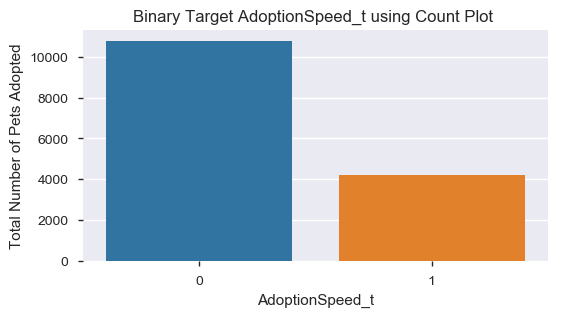

In [49]:
## Count Plot for Binary Target Variable
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('AdoptionSpeed_t', data=data_r2)
ax.set_title('Binary Target AdoptionSpeed_t using Count Plot ')
ax.set_xlabel('AdoptionSpeed_t')
ax.set_ylabel('Total Number of Pets Adopted')

plt.show()

In [50]:
## Creating another Binary Target and merging 0 to 2 and then 3 and 4
data_r2["AdoptionSpeed_t2"]=data_r2["AdoptionSpeed"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength  Vaccinated  Dewormed  Sterilized  Health  Quantity  Fee  State  \
0          1           2         2           2       1         1  100  41326   

   AdoptionSpeed  AdoptionSpeed_t  AdoptionSpeed_t2  
0              2                0                 2

In [51]:
## Binnng AdoptionSpeed for 0 to 2 as 0 and 3 to 4 as 1
data_r2.AdoptionSpeed_t2[data_r2.AdoptionSpeed == 0] = 0
data_r2.AdoptionSpeed_t2[data_r2.AdoptionSpeed == 1] = 0
data_r2.AdoptionSpeed_t2[data_r2.AdoptionSpeed == 2] = 0
data_r2.AdoptionSpeed_t2[data_r2.AdoptionSpeed == 3] = 1
data_r2.AdoptionSpeed_t2[data_r2.AdoptionSpeed == 4] = 1

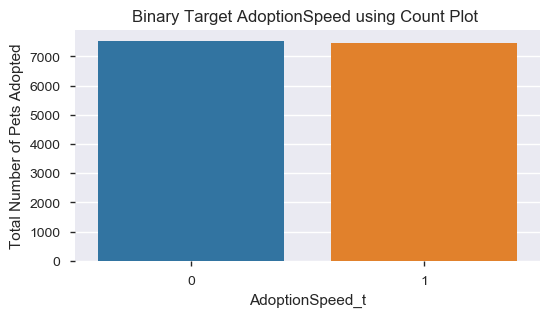

In [52]:
## Creating a Count Plot for the second Binned Target
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('AdoptionSpeed_t2', data=data_r2)
ax.set_title('Binary Target AdoptionSpeed using Count Plot ')
ax.set_xlabel('AdoptionSpeed_t')
ax.set_ylabel('Total Number of Pets Adopted')

plt.show()

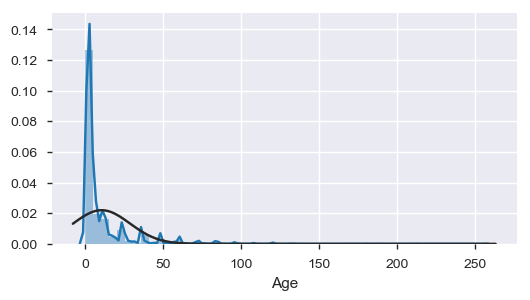

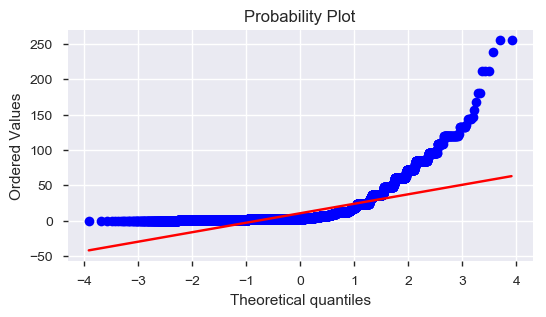

In [53]:
#histogram and normal probability plot for Age
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(data_r2['Age'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(data_r['Age'], plot=plt)

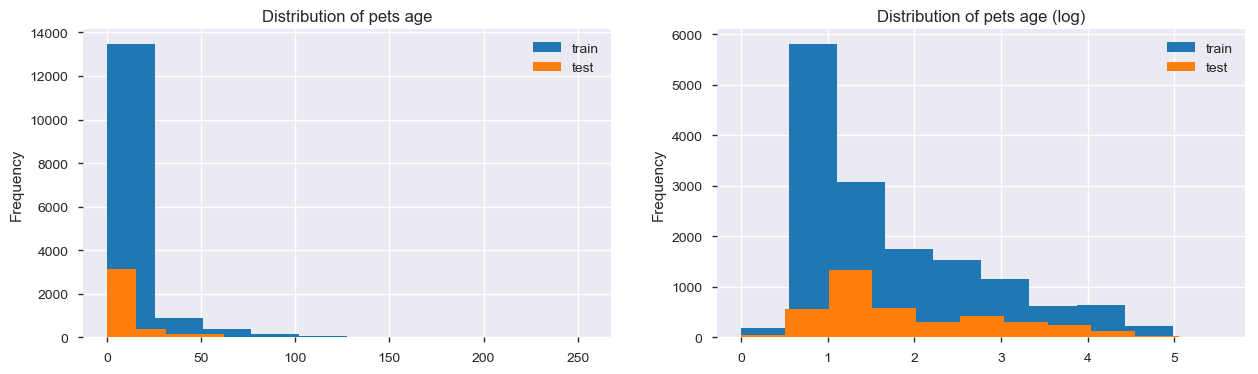

In [54]:
## Distribution of Age for the test and training datasets
fig, ax = plt.subplots(figsize = (15, 4))
plt.subplot(1, 2, 1)
plt.title('Distribution of pets age');
train['Age'].plot('hist', label='train');
test['Age'].plot('hist', label='test');
plt.legend();

plt.subplot(1, 2, 2)
plt.title('Distribution of pets age (log)');
np.log1p(train['Age']).plot('hist', label='train');
np.log1p(test['Age']).plot('hist', label='test');
plt.legend();

In [55]:
## Value Counts for the Age in the training data set
train['Age'].value_counts().head(10)

2     3503
1     2304
3     1966
4     1109
12     967
24     651
5      595
6      558
36     417
8      309
Name: Age, dtype: int64

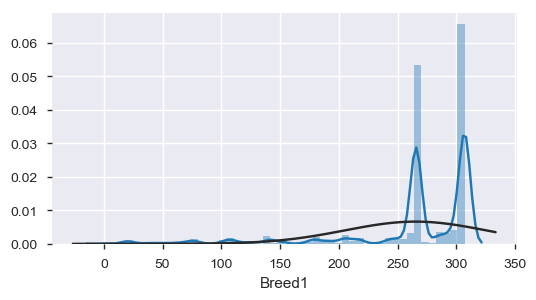

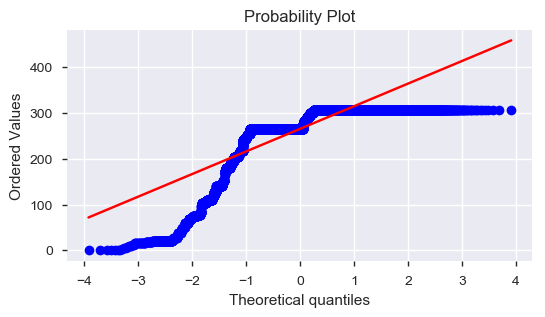

In [56]:
#histogram and normal probability plot for Breed1
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(data_r['Breed1'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(data_r['Breed1'], plot=plt)

In [57]:
##Creating the mixed and pure breed categories

train['Pure_breed'] = 0
train.loc[train['Breed2'] == 0, 'Pure_breed'] = 1
test['Pure_breed'] = 0
test.loc[test['Breed2'] == 0, 'Pure_breed'] = 1
all_data['Pure_breed'] = 0
all_data.loc[all_data['Breed2'] == 0, 'Pure_breed'] = 1

print(f"Rate of pure breed pets in train data: {train['Pure_breed'].sum() * 100 / train['Pure_breed'].shape[0]:.4f}%.")
print(f"Rate of pure breed pets in test data: {test['Pure_breed'].sum() * 100 / test['Pure_breed'].shape[0]:.4f}%.")

Rate of pure breed pets in train data: 71.7802%.
Rate of pure breed pets in test data: 74.6979%.


In [58]:
## CHecking columns for dataset
all_data.columns

Index(['AdoptionSpeed', 'Age', 'Breed1', 'Breed2', 'Color1', 'Color2',
       'Color3', 'Description', 'Dewormed', 'Fee', 'FurLength', 'Gender',
       'Health', 'MaturitySize', 'Name', 'PetID', 'PhotoAmt', 'Quantity',
       'RescuerID', 'State', 'Sterilized', 'Type', 'Vaccinated', 'VideoAmt',
       'dataset_type', 'Pure_breed'],
      dtype='object')

In [59]:
## Checking the dataset for all columns
all_data_train=all_data[all_data["dataset_type"] == 'train']
all_data_train.describe()

AdoptionSpeed           Age        Breed1        Breed2        Color1  \
count   14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean        2.516441     10.452078    265.272594     74.009738      2.234176   
std         1.177265     18.155790     60.056818    123.011575      1.745225   
min         0.000000      0.000000      0.000000      0.000000      1.000000   
25%         2.000000      2.000000    265.000000      0.000000      1.000000   
50%         2.000000      3.000000    266.000000      0.000000      2.000000   
75%         4.000000     12.000000    307.000000    179.000000      3.000000   
max         4.000000    255.000000    307.000000    307.000000      7.000000   

             Color2        Color3      Dewormed           Fee     FurLength  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       3.222837      1.882012      1.558727     21.259988      1.467485   
std        2.742562      2.984086      0.695817     78.414548      0.599070   
min        0.000000      0.000000      1.000000      0.000000      1.000000   
25%        0.000000      0.000000      1.000000      0.000000      1.000000   
50%        2.000000      0.000000      1.000000      0.000000      1.000000   
75%        6.000000      5.000000      2.000000      0.000000      2.000000   
max        7.000000      7.000000      3.000000   3000.000000      3.000000   

           ...             Health  MaturitySize      PhotoAmt      Quantity  \
count      ...       14993.000000  14993.000000  14993.000000  14993.000000   
mean       ...           1.036617      1.862002      3.889215      1.576069   
std        ...           0.199535      0.547959      3.487810      1.472477   
min        ...           1.000000      1.000000      0.000000      1.000000   
25%        ...           1.000000      2.000000      2.000000      1.000000   
50%        ...           1.000000      2.000000      3.000000      1.000000   
75%        ...           1.000000      2.000000      5.000000      1.000000   
max        ...           3.000000      4.000000     30.000000     20.000000   

              State    Sterilized          Type    Vaccinated      VideoAmt  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean   41346.028347      1.914227      1.457614      1.731208      0.056760   
std       32.444153      0.566172      0.498217      0.667649      0.346185   
min    41324.000000      1.000000      1.000000      1.000000      0.000000   
25%    41326.000000      2.000000      1.000000      1.000000      0.000000   
50%    41326.000000      2.000000      1.000000      2.000000      0.000000   
75%    41401.000000      2.000000      2.000000      2.000000      0.000000   
max    41415.000000      3.000000      2.000000      3.000000      8.000000   

         Pure_breed  
count  14993.000000  
mean       0.717802  
std        0.450084  
min        0.000000  
25%        0.000000  
50%        1.000000  
75%        1.000000  
max        1.000000  

[8 rows x 21 columns]

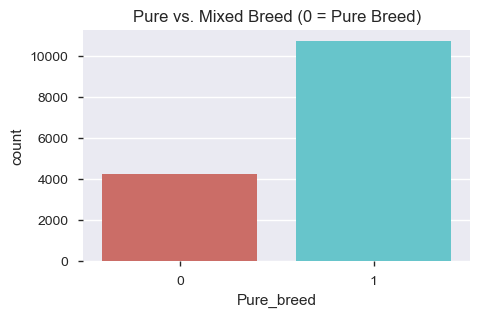

In [60]:
#draw histogram plot for the binned data 
count, ax = plt.subplots(figsize=(5,3))
sns.countplot(x = 'Pure_breed', data = all_data_train, palette = 'hls')
plt.title('Pure vs. Mixed Breed (0 = Pure Breed)')
plt.show()

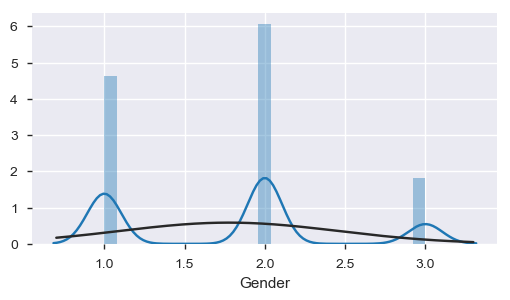

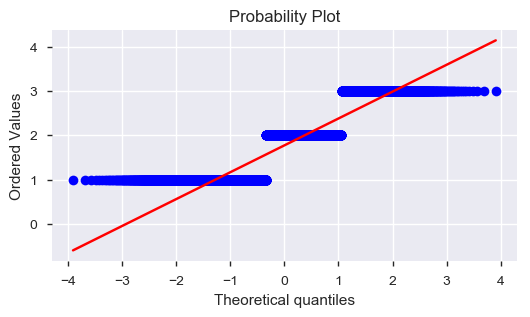

In [61]:
#histogram and normal probability plot for Gender 
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(data_r2['Gender'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(data_r['Gender'], plot=plt)

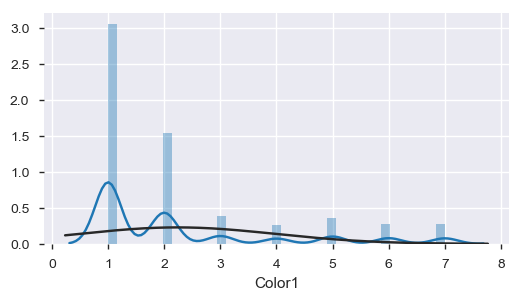

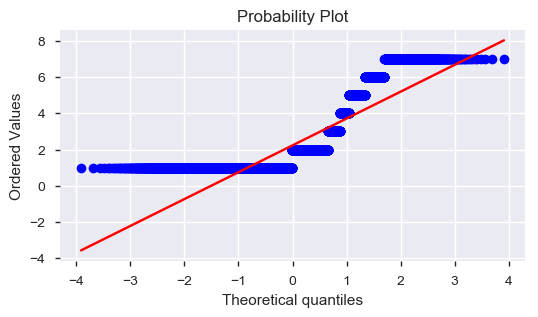

In [62]:
#histogram and normal probability plot for Color1
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(data_r['Color1'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(data_r['Color1'], plot=plt)

In [63]:
## Color1 counts for the training and testing data sets for both types 
colors_dict = {k: v for k, v in zip(colors['ColorID'], colors['ColorName'])}
train['Color1_name'] = train['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color2_name'] = train['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
train['Color3_name'] = train['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

test['Color1_name'] = test['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color2_name'] = test['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
test['Color3_name'] = test['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

all_data['Color1_name'] = all_data['Color1'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color2_name'] = all_data['Color2'].apply(lambda x: colors_dict[x] if x in colors_dict else '')
all_data['Color3_name'] = all_data['Color3'].apply(lambda x: colors_dict[x] if x in colors_dict else '')

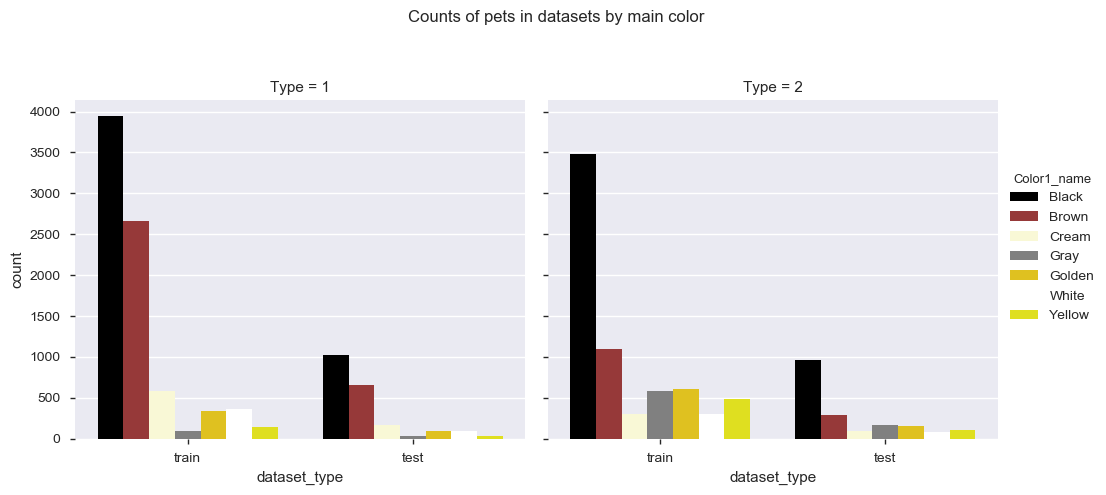

In [64]:
### Count plots for the Color1 dataset 
sns.factorplot('dataset_type', col='Type', data=all_data, kind='count', hue='Color1_name', palette=['Black', 'Brown', '#FFFDD0', 'Gray', 'Gold', 'White', 'Yellow']);
plt.subplots_adjust(top=0.8)
plt.suptitle('Counts of pets in datasets by main color');

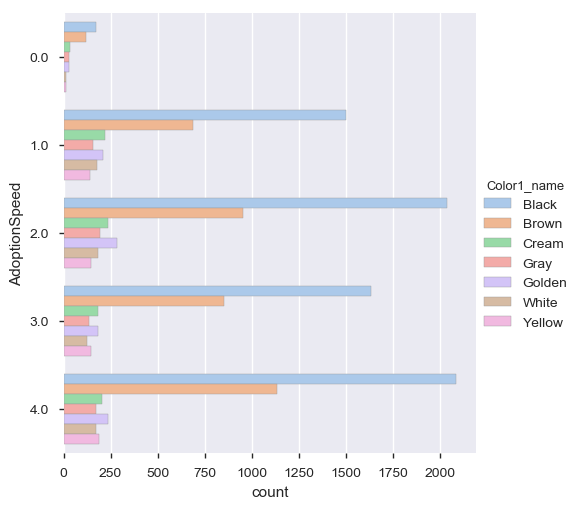

In [65]:
## Barplot and Countplot in Seaborn for Color1 and adoptionspeed

sns.catplot(y="AdoptionSpeed", 
            hue="Color1_name", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=all_data);

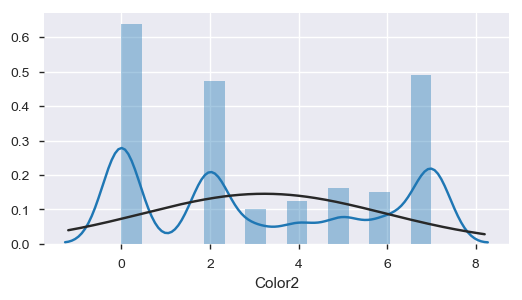

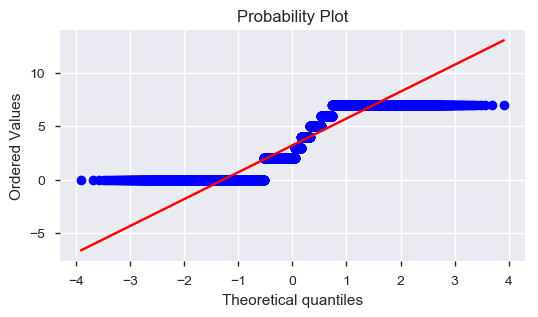

In [66]:
#histogram and normal probability plot for Color2
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(data_r2['Color2'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(data_r2['Color2'], plot=plt)

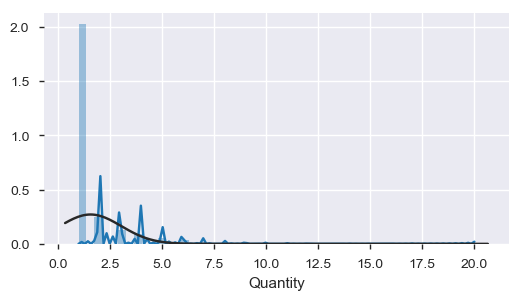

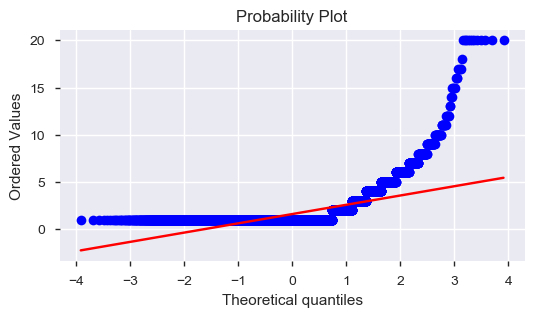

In [67]:
#histogram and normal probability plot for Quantity
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(data_r['Quantity'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(data_r['Quantity'], plot=plt)

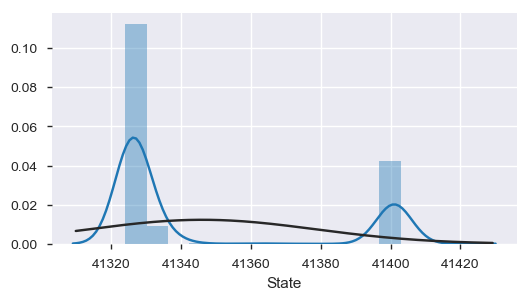

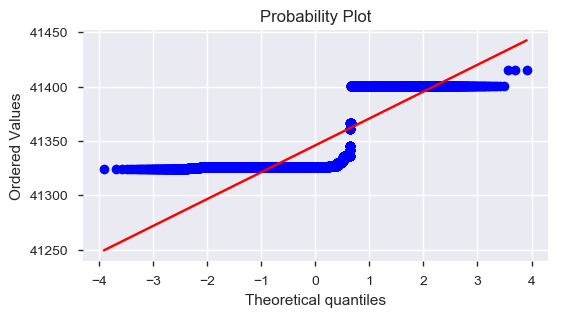

In [68]:
#histogram and normal probability plot for State
count, ax = plt.subplots(figsize=(6,3))
sns.distplot(data_r2['State'], fit=norm);

count, ax = plt.subplots(figsize=(6,3))
res = stats.probplot(data_r2['State'], plot=plt)

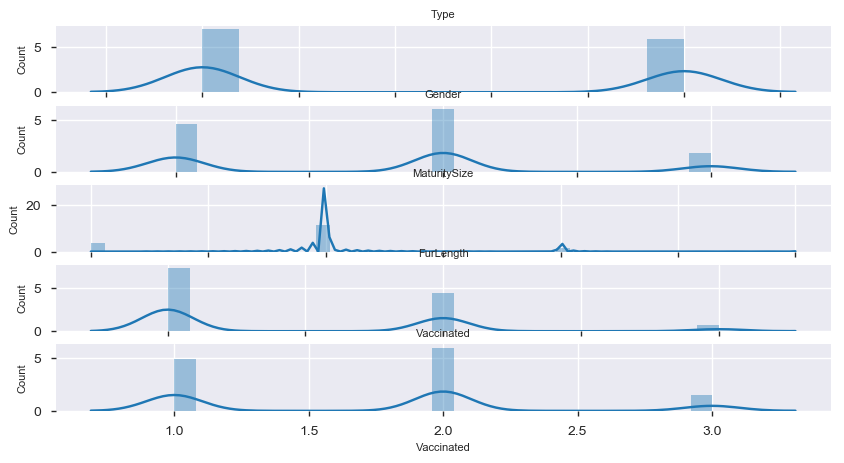

In [69]:
## distribution plots for the five attributes
col_names = ['Type','Gender', 'MaturitySize', 'FurLength', 'Vaccinated']

fig, ax = plt.subplots(len(col_names), figsize=(10,5))

for i, col_val in enumerate(col_names):

    sns.distplot(data_r[col_val], hist=True, ax=ax[i])
    ax[i].set_title(col_val, fontsize=8)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

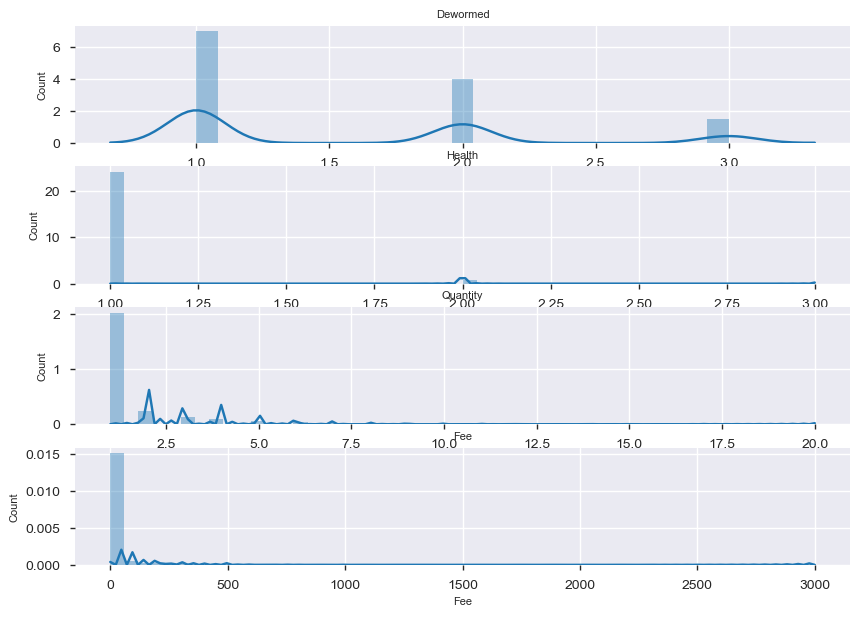

In [70]:
## distribution plots for the four attributes
col_names = ['Dewormed', 'Health', 'Quantity', 'Fee']

fig, ax = plt.subplots(len(col_names), figsize=(10,7))

for i, col_val in enumerate(col_names):

    sns.distplot(data_r[col_val], hist=True, ax=ax[i])
    ax[i].set_title(col_val, fontsize=8)
    ax[i].set_xlabel(col_val, fontsize=8)
    ax[i].set_ylabel('Count', fontsize=8)

plt.show()

In [71]:
###### Bivariate Graph Analysis continued

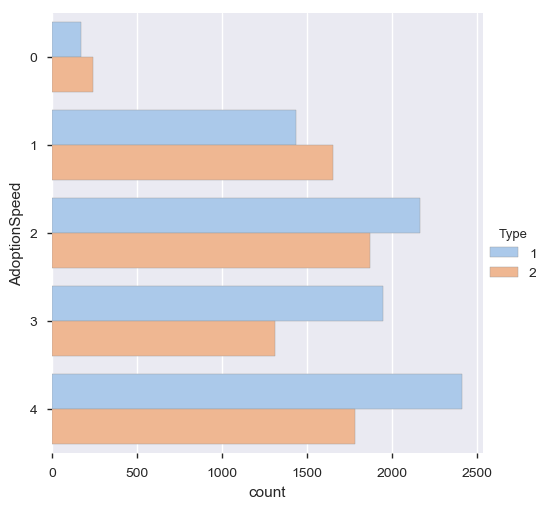

In [72]:
## Barplot and Countplot in Seaborn for Type
sns.catplot(y="AdoptionSpeed", 
            hue="Type", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [73]:
# Cross Tabulation for Categorical Variable Type and Adoptionspeed 

pd.crosstab(data_r2.AdoptionSpeed, data_r2.Type, margins=True)

Type              1     2    All
AdoptionSpeed                   
0               170   240    410
1              1435  1655   3090
2              2164  1873   4037
3              1949  1310   3259
4              2414  1783   4197
All            8132  6861  14993

In [74]:
## Plotting the differences for adoption rates baed on Type
df=data_r

main_count = df['AdoptionSpeed'].value_counts(normalize=True).sort_index()
def prepare_plot_dict(df, col, main_count):
    """
    Preparing dictionary with data for plotting.
    
    I want to show how much higher/lower are the rates of Adoption speed for the current column comparing to base values (as described higher),
    At first I calculate base rates, then for each category in the column I calculate rates of Adoption speed and find difference with the base rates.
    
    """
    main_count = dict(main_count)
    plot_dict = {}
    for i in df[col].unique():
        val_count = dict(df.loc[df[col] == i, 'AdoptionSpeed'].value_counts().sort_index())

        for k, v in main_count.items():
            if k in val_count:
                plot_dict[val_count[k]] = ((val_count[k] / sum(val_count.values())) / main_count[k]) * 100 - 100
            else:
                plot_dict[0] = 0

    return plot_dict

def make_count_plot(df, x, hue='AdoptionSpeed', title='', main_count=main_count):
    """
    Plotting countplot with correct annotations.
    """
    g = sns.countplot(x=x, data=df, hue=hue);
    plt.title(f'AdoptionSpeed {title}');
    ax = g.axes

    plot_dict = prepare_plot_dict(df, x, main_count)

    for p in ax.patches:
        h = p.get_height() if str(p.get_height()) != 'nan' else 0
        text = f"{plot_dict[h]:.0f}%" if plot_dict[h] < 0 else f"+{plot_dict[h]:.0f}%"
        ax.annotate(text, (p.get_x() + p.get_width() / 2., h),
             ha='center', va='center', fontsize=11, color='green' if plot_dict[h] > 0 else 'red', rotation=0, xytext=(0, 10),
             textcoords='offset points')  

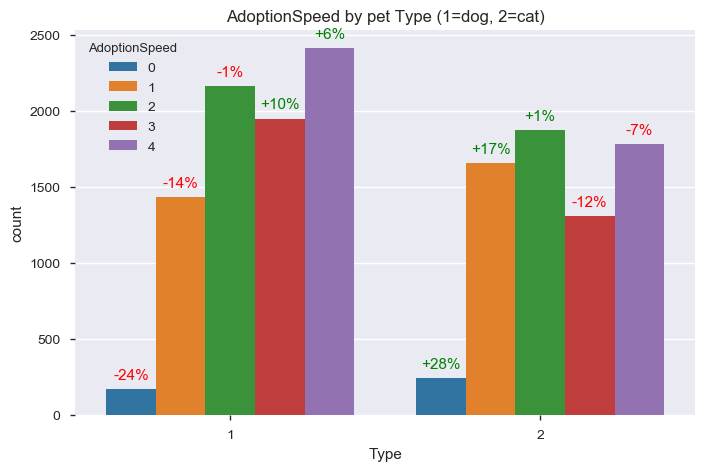

In [75]:
## Count plot for AdoptionSpeed by pet Type
count, ax = plt.subplots(figsize=(8, 5));
make_count_plot(df, x='Type', title='by pet Type (1=dog, 2=cat)')

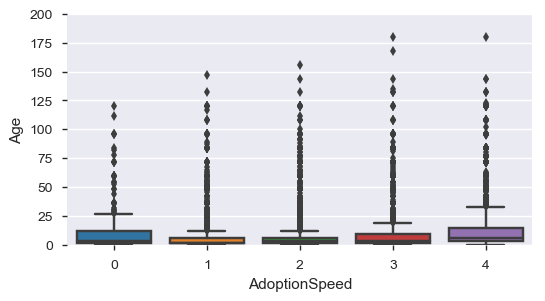

In [76]:
## Box and Whisker Plot for Age and AdoptionSpeed
count, ax = plt.subplots(figsize=(6,3))
fig = sns.boxplot(x='AdoptionSpeed', y="Age", data=data_r2)
fig.axis(ymin=0, ymax=200);

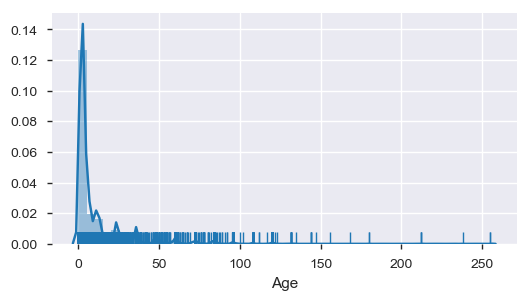

In [77]:
# Hist + Rug + kernel density for Age
count, ax = plt.subplots(figsize=(6,3))
sns.distplot( a=data_r2["Age"], hist=True, kde=True, rug=True )
plt.show()

In [78]:
## Creating a new Age Category
data_r2["Age_t"]=data_r2["Age"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength  ...    Dewormed  Sterilized  Health  Quantity  Fee  State  \
0          1  ...           2           2       1         1  100  41326   

   AdoptionSpeed  AdoptionSpeed_t  AdoptionSpeed_t2  Age_t  
0              2                0                 0      3  

[1 rows x 21 columns]

In [79]:
## Log10 transformation of the Age Attribute
data_r2.Age_t=np.log10(data_r2.Age_t)
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength    ...     Dewormed  Sterilized  Health  Quantity  Fee  State  \
0          1    ...            2           2       1         1  100  41326   

   AdoptionSpeed  AdoptionSpeed_t  AdoptionSpeed_t2     Age_t  
0              2                0                 0  0.477121  

[1 rows x 21 columns]

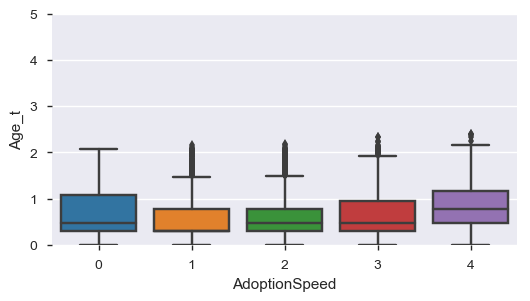

In [80]:
## Box and Whisker plot for the Age_t attribute
count, ax = plt.subplots(figsize=(6,3))
fig = sns.boxplot(x='AdoptionSpeed', y="Age_t", data=data_r2)
fig.axis(ymin=0, ymax=5);

In [81]:
# Cross Tabulation for Categorical Variables of Age and AdoptionSpeed

pd.crosstab(data_r2.AdoptionSpeed, data_r2.Age, margins=True)

Age              0     1     2     3     4    5    6    7    8    9  ...    \
AdoptionSpeed                                                        ...     
0               10    54   115    44    24    7   20    7    4    5  ...     
1               50   643   865   408   211  100   80   43   36   24  ...     
2               44   754  1120   586   265  157  117   59   68   51  ...     
3               39   511   783   458   260  135  115   62   70   31  ...     
4               36   342   620   470   349  196  226  110  131   73  ...     
All            179  2304  3503  1966  1109  595  558  281  309  184  ...     

Age            135  144  147  156  168  180  212  238  255    All  
AdoptionSpeed                                                      
0                0    0    0    0    0    0    0    0    0    410  
1                0    0    1    0    0    0    0    0    0   3090  
2                0    1    0    1    0    0    0    0    0   4037  
3                1    1    0    0    1    1    2    0    0   3259  
4                0    2    0    0    0    1    1    1    2   4197  
All              1    4    1    1    1    2    3    1    2  14993  

[6 rows x 107 columns]

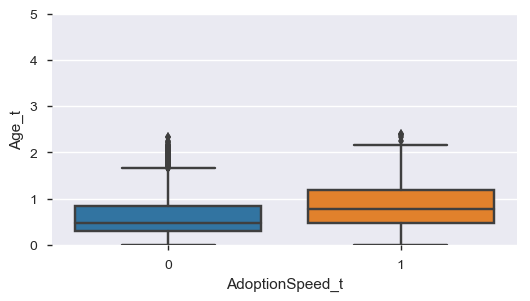

In [82]:
## Box and whiskerplot for the Age_t and AdoptionSpeed_t
count, ax = plt.subplots(figsize=(6,3));
fig = sns.boxplot(x='AdoptionSpeed_t', y="Age_t", data=data_r2)
fig.axis(ymin=0, ymax=5)
plt.show()

(-0.5, 1.5, 0, 3)

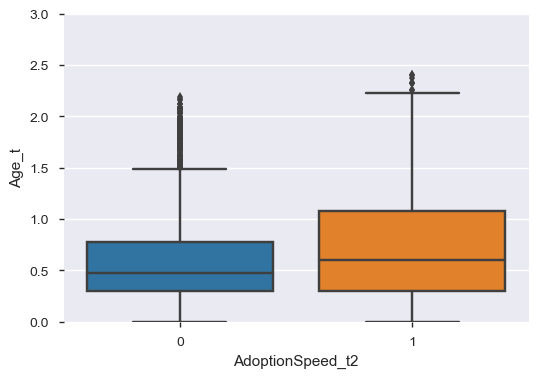

In [83]:
## Box and whiskerplot for the Age_t and AdoptionSpeed_t2
plt.figure(figsize=(6, 4));
fig = sns.boxplot(x='AdoptionSpeed_t2', y="Age_t", data=data_r2)
fig.axis(ymin=0, ymax=3)

In [84]:
#set up bins for new Age Attribute
bin = [0, 1, 2, 3, 5, 10, 25, 255]

#use pd.cut function can attribute the values into its specific bins
category = pd.cut(data_r2.Age, bin)
category = category.to_frame()
category.columns = ['Age_b']

#concatenate age and its bin
data_r2 = pd.concat([data_r2,category],axis = 1)
data_r2.head(3)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   
1     2    1     265       0       1       1       2       0             2   
2     1    1     307       0       1       2       7       0             2   

   FurLength   ...    Sterilized  Health  Quantity  Fee  State  AdoptionSpeed  \
0          1   ...             2       1         1  100  41326              2   
1          2   ...             3       1         1    0  41401              0   
2          2   ...             2       1         1    0  41326              3   

   AdoptionSpeed_t  AdoptionSpeed_t2     Age_t   Age_b  
0                0                 0  0.477121  (2, 3]  
1                0                 0  0.000000  (0, 1]  
2                0                 1  0.000000  (0, 1]  

[3 rows x 22 columns]

In [85]:
## Creating the bin categories
data_r2['Age_bin'] = pd.cut(x=data_r2['Age'], bins=[0, 1, 2, 3, 5, 10, 25, 255], labels=['1','2','3','5','10','25','255'])

In [86]:
## Checking the bins
data_r2.head(3)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   
1     2    1     265       0       1       1       2       0             2   
2     1    1     307       0       1       2       7       0             2   

   FurLength   ...     Health  Quantity  Fee  State  AdoptionSpeed  \
0          1   ...          1         1  100  41326              2   
1          2   ...          1         1    0  41401              0   
2          2   ...          1         1    0  41326              3   

   AdoptionSpeed_t  AdoptionSpeed_t2     Age_t   Age_b  Age_bin  
0                0                 0  0.477121  (2, 3]        3  
1                0                 0  0.000000  (0, 1]        1  
2                0                 1  0.000000  (0, 1]        1  

[3 rows x 23 columns]

In [87]:
# Cross Tabulation for Categorical Variables 
pd.crosstab(data_r2.AdoptionSpeed_t, data_r2.Age_bin, margins=True)

Age_bin             1     2     3     5    10    25   255    All
AdoptionSpeed_t                                                 
0                1962  2883  1496  1159   893  1300   960  10653
1                 342   620   470   545   601  1012   571   4161
All              3503  1494  2304  1966  1531  1704  2312  14814

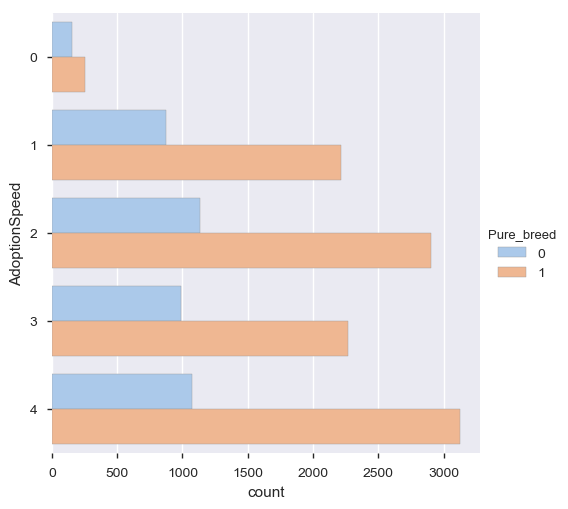

In [88]:
## Barplot and Countplot in Seaborn
sns.catplot(y="AdoptionSpeed", 
            hue="Pure_breed", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=train);

In [89]:
## Binning the Breed1 Category
data_r2["Breed1_t"]=data_r2["Breed1"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength    ...     Quantity  Fee  State  AdoptionSpeed  AdoptionSpeed_t  \
0          1    ...            1  100  41326              2                0   

   AdoptionSpeed_t2     Age_t   Age_b  Age_bin  Breed1_t  
0                 0  0.477121  (2, 3]        3       299  

[1 rows x 24 columns]

In [90]:
## Binning unique values in Breed1 into a total of 4 unique bins 
data_r2.Breed1_t[data_r2.Breed1_t == 307] = 500
data_r2.Breed1_t[data_r2.Breed1_t == 266] = 400

In [91]:
## Binning unique values in Breed1 into a total of 4 unique bins 
data_r2.Breed1_t[data_r2.Breed1_t <= 240] = 350

In [92]:
## Binning unique values in Breed1 into a total of 4 unique bins 
data_r2.Breed1_t[data_r2.Breed1_t <= 306] = 325

In [93]:
## Binning unique values in Breed1 into a total of 4 unique bins  
data_r2.Breed1_t.unique()

array([325, 500, 400, 350], dtype=int64)

In [94]:
## Restoring the values
data_r2.Breed1_t[data_r2.Breed1_t == 500] = 307
data_r2.Breed1_t[data_r2.Breed1_t == 400] = 266
data_r2.Breed1_t[data_r2.Breed1_t == 325] = 275
data_r2.Breed1_t[data_r2.Breed1_t == 350] = 265

In [95]:
## Data check for the four bins
data_r2.Breed1_t.unique()

array([275, 307, 266, 265], dtype=int64)

In [96]:
# Cross Tabulation for Categorical Variables 

pd.crosstab(data_r2.Breed1_t, data_r2.Age_bin, margins=True)

Age_bin      1     2     3     5    10    25   255    All
Breed1_t                                                 
265        128   226   147   162   217   502   819   2201
266        548   879   568   552   397   482   149   3575
275        463   640   454   437   422   563   201   3180
307       1165  1758   797   553   458   765   362   5858
All       3503  1494  2304  1966  1531  1704  2312  14814

In [97]:
# Cross Tabulation for Categorical Variables 

pd.crosstab(data_r2.Breed1_t, data_r2.AdoptionSpeed_t, margins=True)

AdoptionSpeed_t      0     1    All
Breed1_t                           
265               1827   391   2218
266               2658   976   3634
275               2415   799   3214
307               3896  2031   5927
All              10796  4197  14993

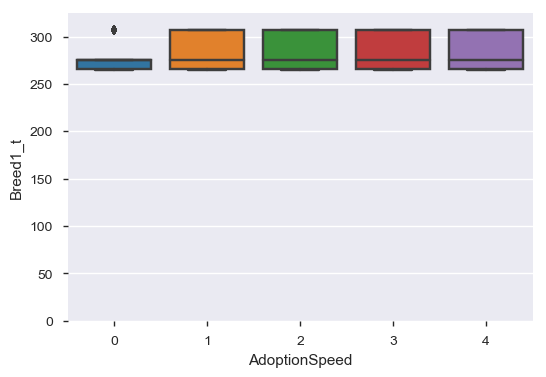

In [98]:
## Box and Whiskers Plot for AdoptionSpeed and Breed1_t
plt.figure(figsize=(6, 4));
fig = sns.boxplot(x='AdoptionSpeed', y="Breed1_t", data=data_r2)
fig.axis(ymin=0, ymax=325);

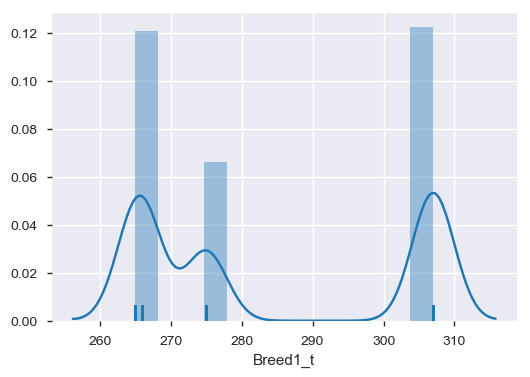

In [99]:
# Hist + Rug + kernel density for Breed1_t 
plt.figure(figsize=(6, 4));
sns.distplot( a=data_r2["Breed1_t"], hist=True, kde=True, rug=True )
plt.show()

In [100]:
## Creating a binned category for Fee
data_r2["Fee_t"]=data_r2["Fee"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength  ...    Fee  State  AdoptionSpeed  AdoptionSpeed_t  \
0          1  ...    100  41326              2                0   

   AdoptionSpeed_t2     Age_t   Age_b  Age_bin  Breed1_t  Fee_t  
0                 0  0.477121  (2, 3]        3       275    100  

[1 rows x 25 columns]

In [101]:
## Binnng the all values that have counts less than 500
data_r2.Fee_t[data_r2.Fee_t == 0] = 0
data_r2.Fee_t[data_r2.Fee_t > 0] = 1

data_r2.head(3)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   
1     2    1     265       0       1       1       2       0             2   
2     1    1     307       0       1       2       7       0             2   

   FurLength  ...    Fee  State  AdoptionSpeed  AdoptionSpeed_t  \
0          1  ...    100  41326              2                0   
1          2  ...      0  41401              0                0   
2          2  ...      0  41326              3                0   

   AdoptionSpeed_t2     Age_t   Age_b  Age_bin  Breed1_t  Fee_t  
0                 0  0.477121  (2, 3]        3       275      1  
1                 0  0.000000  (0, 1]        1       275      0  
2                 1  0.000000  (0, 1]        1       307      0  

[3 rows x 25 columns]

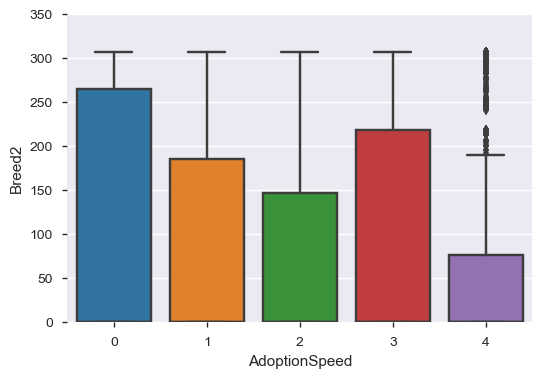

In [102]:
## Box and whiskers for Breed2
plt.figure(figsize=(6, 4));
fig = sns.boxplot(x='AdoptionSpeed', y="Breed2", data=data_r2)
fig.axis(ymin=0, ymax=350);

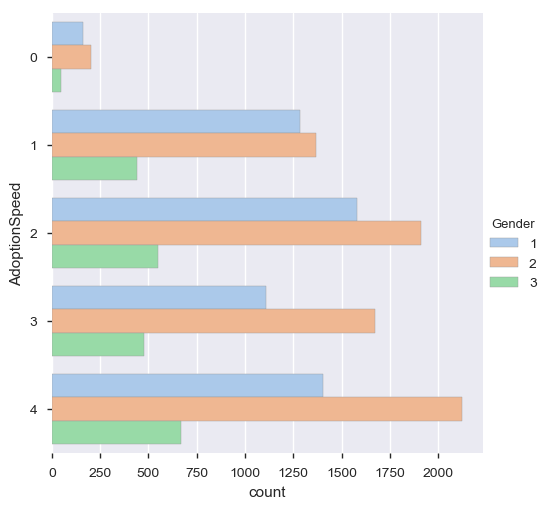

In [103]:
## Barplot and Countplot in Seaborn for Gender and AS
sns.catplot(y="AdoptionSpeed", 
            hue="Gender", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [104]:
# Cross Tabulation for Categorical Variables for Gender and AS 

pd.crosstab(data_r2.AdoptionSpeed, data_r2.Gender, margins=True)

Gender            1     2     3    All
AdoptionSpeed                         
0               160   204    46    410
1              1283  1366   441   3090
2              1578  1911   548   4037
3              1109  1671   479   3259
4              1406  2125   666   4197
All            5536  7277  2180  14993

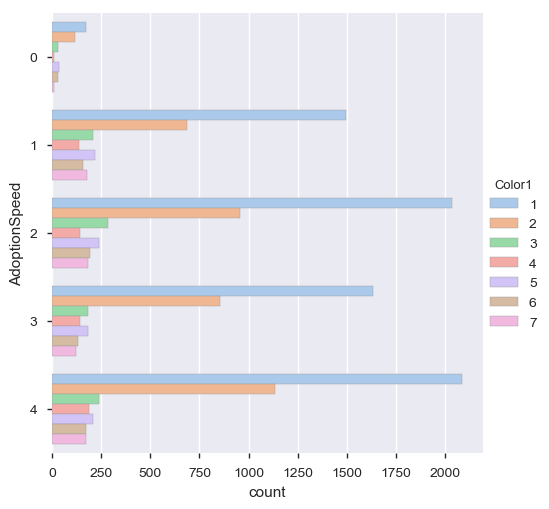

In [105]:
## Barplot and Countplot in Seaborn for Color1 and AS
sns.catplot(y="AdoptionSpeed", 
            hue="Color1", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [106]:
# Cross Tabulation for Categorical Variables for Color1 and AS

pd.crosstab(data_r2.AdoptionSpeed, data_r2.Color1, margins=True)

Color1            1     2    3    4    5    6    7    All
AdoptionSpeed                                            
0               173   119   29   13   34   29   13    410
1              1498   689  211  140  220  156  176   3090
2              2036   956  285  145  238  195  182   4037
3              1633   854  184  145  185  133  125   3259
4              2087  1132  238  191  207  171  171   4197
All            7427  3750  947  634  884  684  667  14993

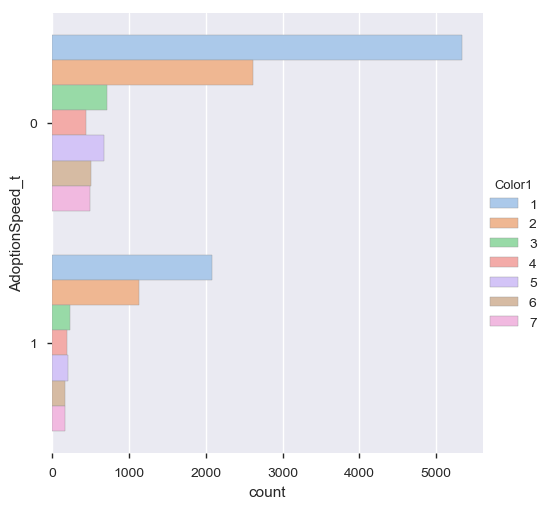

In [107]:
## Barplot and Countplot in Seaborn for Color1 and AS_1
sns.catplot(y="AdoptionSpeed_t", 
            hue="Color1", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

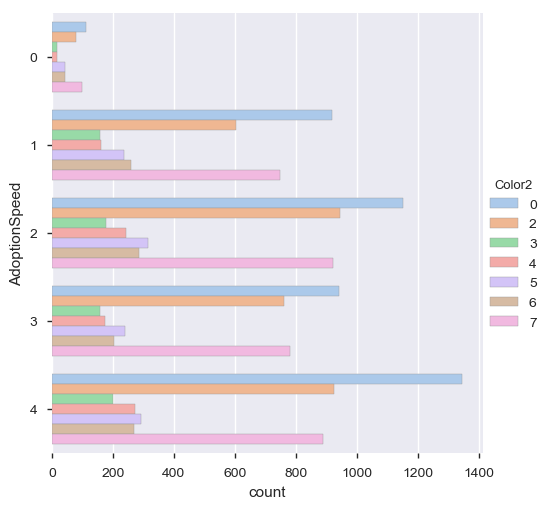

In [108]:
## Barplot and Countplot in Seaborn for Color2 and AS
sns.catplot(y="AdoptionSpeed", 
            hue="Color2", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [109]:
# Cross Tabulation for Categorical Variables for Color2 and AS

pd.crosstab(data_r2.AdoptionSpeed, data_r2.Color2, margins=True)

Color2            0     2    3    4     5     6     7    All
AdoptionSpeed                                               
0               112    80   16   18    43    43    98    410
1               920   603  159  162   237   260   749   3090
2              1152   944  176  242   316   286   921   4037
3               941   761  157  174   240   205   781   3259
4              1346   925  202  274   292   269   889   4197
All            4471  3313  710  870  1128  1063  3438  14993

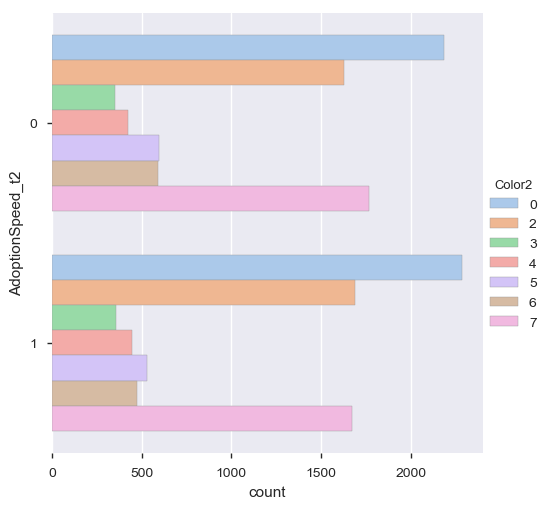

In [110]:
## Barplot and Countplot in Seaborn fpr Color2 and AS_1
sns.catplot(y="AdoptionSpeed_t2", 
            hue="Color2", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

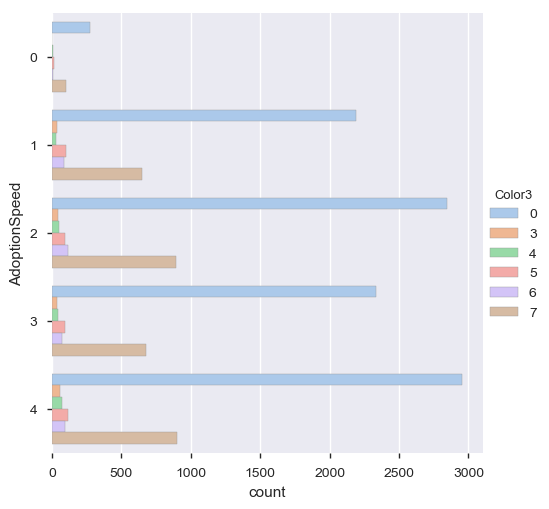

In [111]:
## Barplot and Countplot in Seaborn for Color3
sns.catplot(y="AdoptionSpeed", 
            hue="Color3", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [112]:
# Cross Tabulation for Categorical Variables for Color3 and AS

pd.crosstab(data_r2.AdoptionSpeed, data_r2.Color3, margins=True)

Color3             0    3    4    5    6     7    All
AdoptionSpeed                                        
0                274    3    5   15   10   103    410
1               2189   40   29   99   84   649   3090
2               2848   41   48   94  115   891   4037
3               2337   34   41   94   74   679   3259
4               2956   57   75  115   95   899   4197
All            10604  175  198  417  378  3221  14993

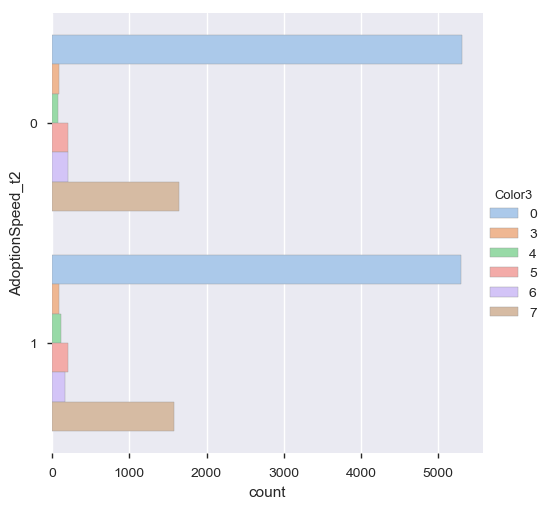

In [113]:
## Barplot and Countplot in Seaborn for Color3 and AS_t2
sns.catplot(y="AdoptionSpeed_t2", 
            hue="Color3", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

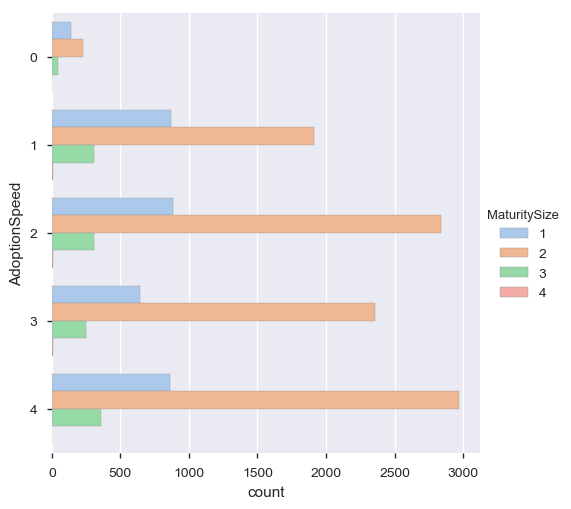

In [114]:
## Barplot and Countplot in Seaborn for Maturity size and AS
sns.catplot(y="AdoptionSpeed", 
            hue="MaturitySize", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [115]:
# Cross Tabulation for Categorical Variables Maturitysize and AS

pd.crosstab(data_r2.AdoptionSpeed, data_r2.MaturitySize, margins=True)

MaturitySize      1      2     3   4    All
AdoptionSpeed                              
0               139    226    43   2    410
1               870   1909   304   7   3090
2               884   2837   305  11   4037
3               641   2360   248  10   3259
4               861   2973   360   3   4197
All            3395  10305  1260  33  14993

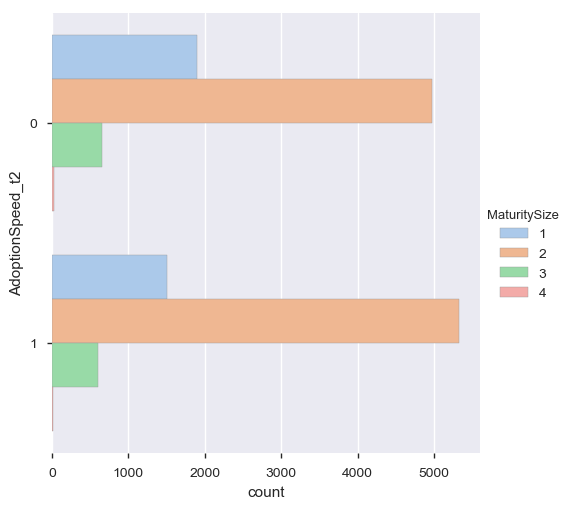

In [116]:
## Barplot and Countplot in Seaborn for Maturity Size and AS_t2
sns.catplot(y="AdoptionSpeed_t2", 
            hue="MaturitySize", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

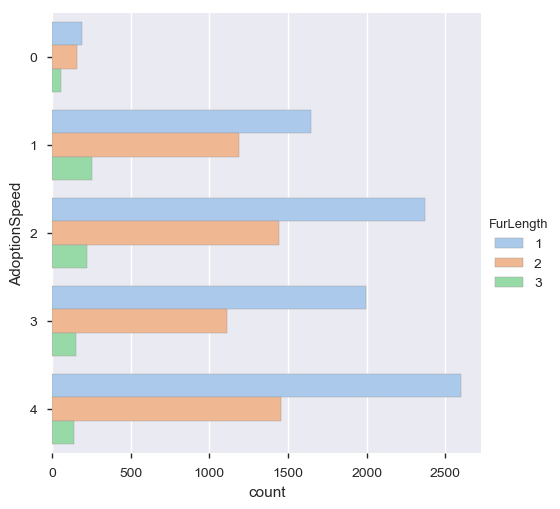

In [117]:
## Barplot and Countplot in Seaborn for FurLength and AS
sns.catplot(y="AdoptionSpeed", 
            hue="FurLength", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [118]:
# Cross Tabulation for Categorical Variables for FurLength and AS

pd.crosstab(data_r2.AdoptionSpeed, data_r2.FurLength, margins=True)

FurLength         1     2    3    All
AdoptionSpeed                        
0               194   160   56    410
1              1649  1187  254   3090
2              2372  1444  221   4037
3              1994  1111  154   3259
4              2599  1459  139   4197
All            8808  5361  824  14993

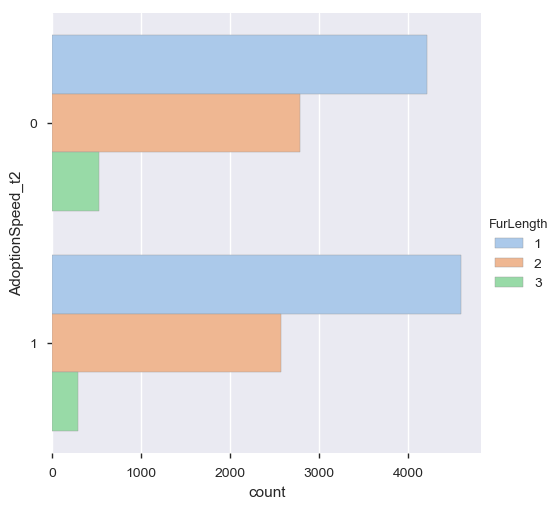

In [119]:
## Barplot and Countplot in Seaborn for FurLenght and AS_t2
sns.catplot(y="AdoptionSpeed_t2", 
            hue="FurLength", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

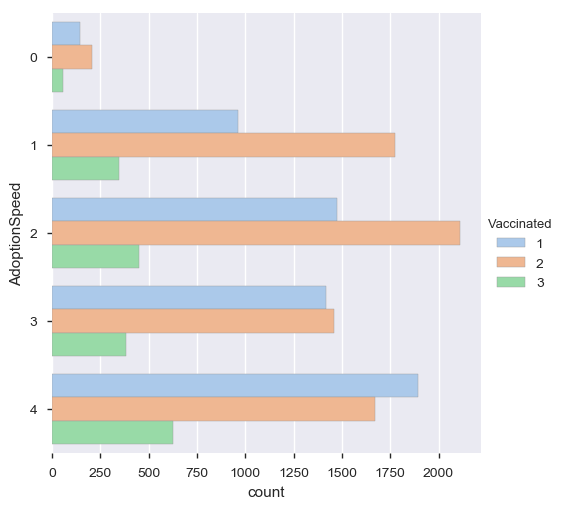

In [120]:
## Barplot and Countplot in Seaborn for Vaccinated and AS
sns.catplot(y="AdoptionSpeed", 
            hue="Vaccinated", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [121]:
# Cross Tabulation for Categorical Variables Vaccinatged and AS

pd.crosstab(data_r2.AdoptionSpeed, data_r2.Vaccinated, margins=True)

Vaccinated        1     2     3    All
AdoptionSpeed                         
0               146   206    58    410
1               965  1777   348   3090
2              1473  2112   452   4037
3              1419  1459   381   3259
4              1895  1673   629   4197
All            5898  7227  1868  14993

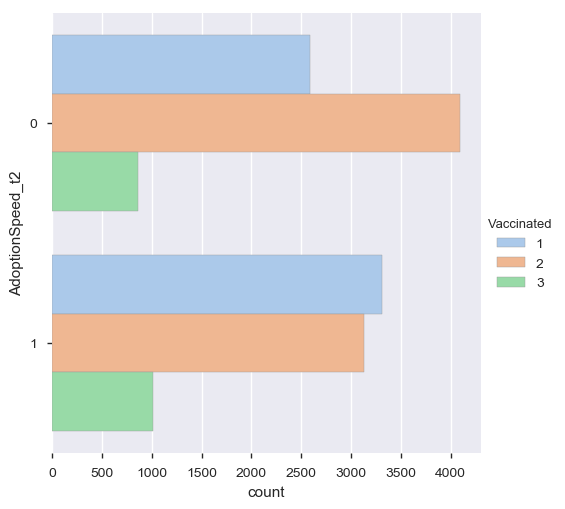

In [122]:
## Barplot and Countplot in Seaborn for Vaccinated and AS_t2
sns.catplot(y="AdoptionSpeed_t2", 
            hue="Vaccinated", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

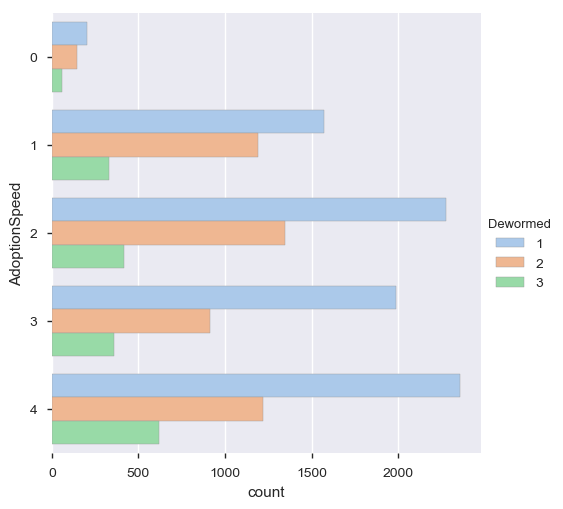

In [123]:
## Barplot and Countplot in Seaborn for Dewormed and AS
sns.catplot(y="AdoptionSpeed", 
            hue="Dewormed", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [124]:
# Cross Tabulation for Categorical Variables for Dewormed and AS

pd.crosstab(data_r2.AdoptionSpeed, data_r2.Dewormed, margins=True)

Dewormed          1     2     3    All
AdoptionSpeed                         
0               205   146    59    410
1              1572  1188   330   3090
2              2273  1347   417   4037
3              1988   914   357   3259
4              2359  1220   618   4197
All            8397  4815  1781  14993

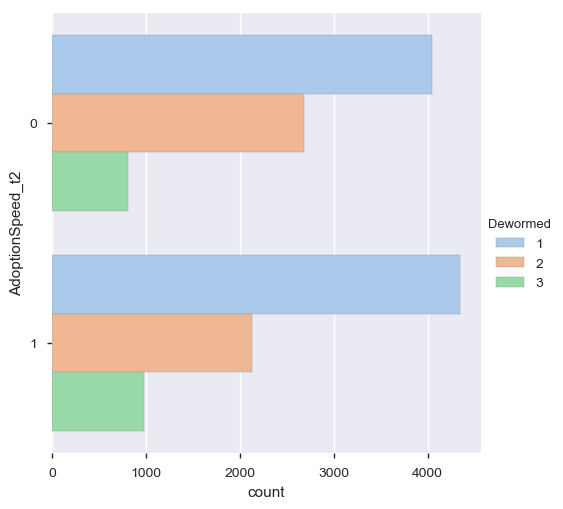

In [125]:
## Barplot and Countplot in Seaborn for Dewormed and AS_t2
sns.catplot(y="AdoptionSpeed_t2", 
            hue="Dewormed", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

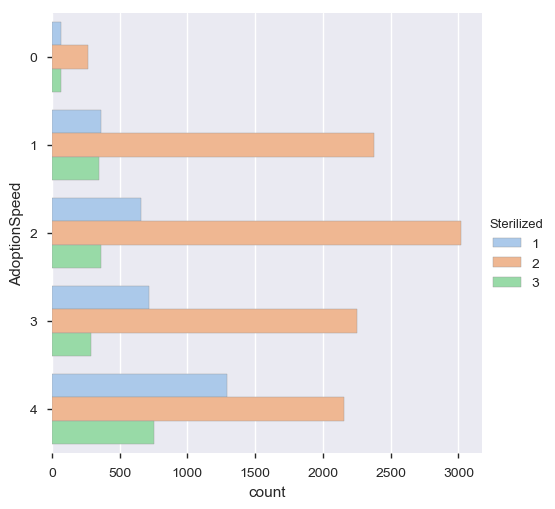

In [126]:
## Barplot and Countplot in Seaborn for Sterilized and AS
sns.catplot(y="AdoptionSpeed", 
            hue="Sterilized", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [127]:
# Cross Tabulation for Categorical Variables for Sterilized and AS

pd.crosstab(data_r2.AdoptionSpeed, data_r2.Sterilized, margins=True)

Sterilized        1      2     3    All
AdoptionSpeed                          
0                70    270    70    410
1               364   2378   348   3090
2               656   3022   359   4037
3               720   2251   288   3259
4              1291   2156   750   4197
All            3101  10077  1815  14993

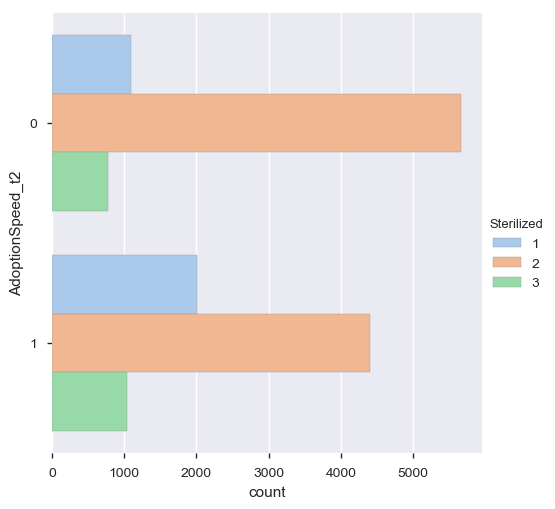

In [128]:
## Barplot and Countplot in Seaborn for Sterilized and AS_t2
sns.catplot(y="AdoptionSpeed_t2", 
            hue="Sterilized", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

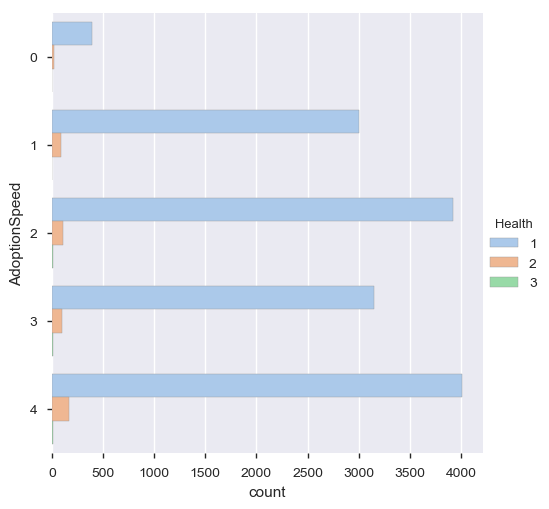

In [129]:
## Barplot and Countplot in Seaborn for Health and AS
sns.catplot(y="AdoptionSpeed", 
            hue="Health", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [130]:
# Cross Tabulation for Categorical Variables for Health and AS

pd.crosstab(data_r2.AdoptionSpeed, data_r2.Health, margins=True)

Health             1    2   3    All
AdoptionSpeed                       
0                392   17   1    410
1               2999   89   2   3090
2               3925  106   6   4037
3               3150   98  11   3259
4               4012  171  14   4197
All            14478  481  34  14993

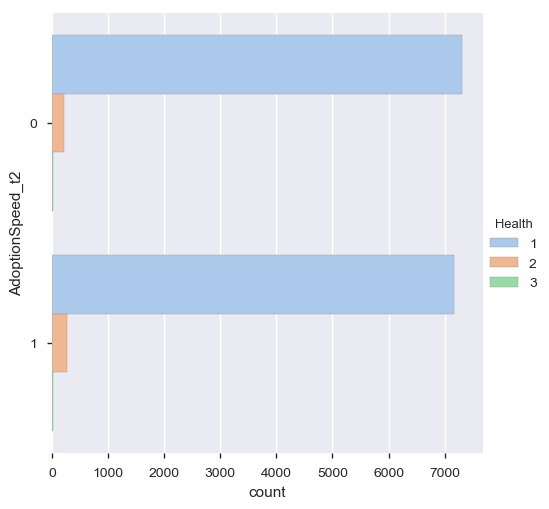

In [131]:
## Barplot and Countplot in Seaborn for Health and AS_t2
sns.catplot(y="AdoptionSpeed_t2", 
            hue="Health", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

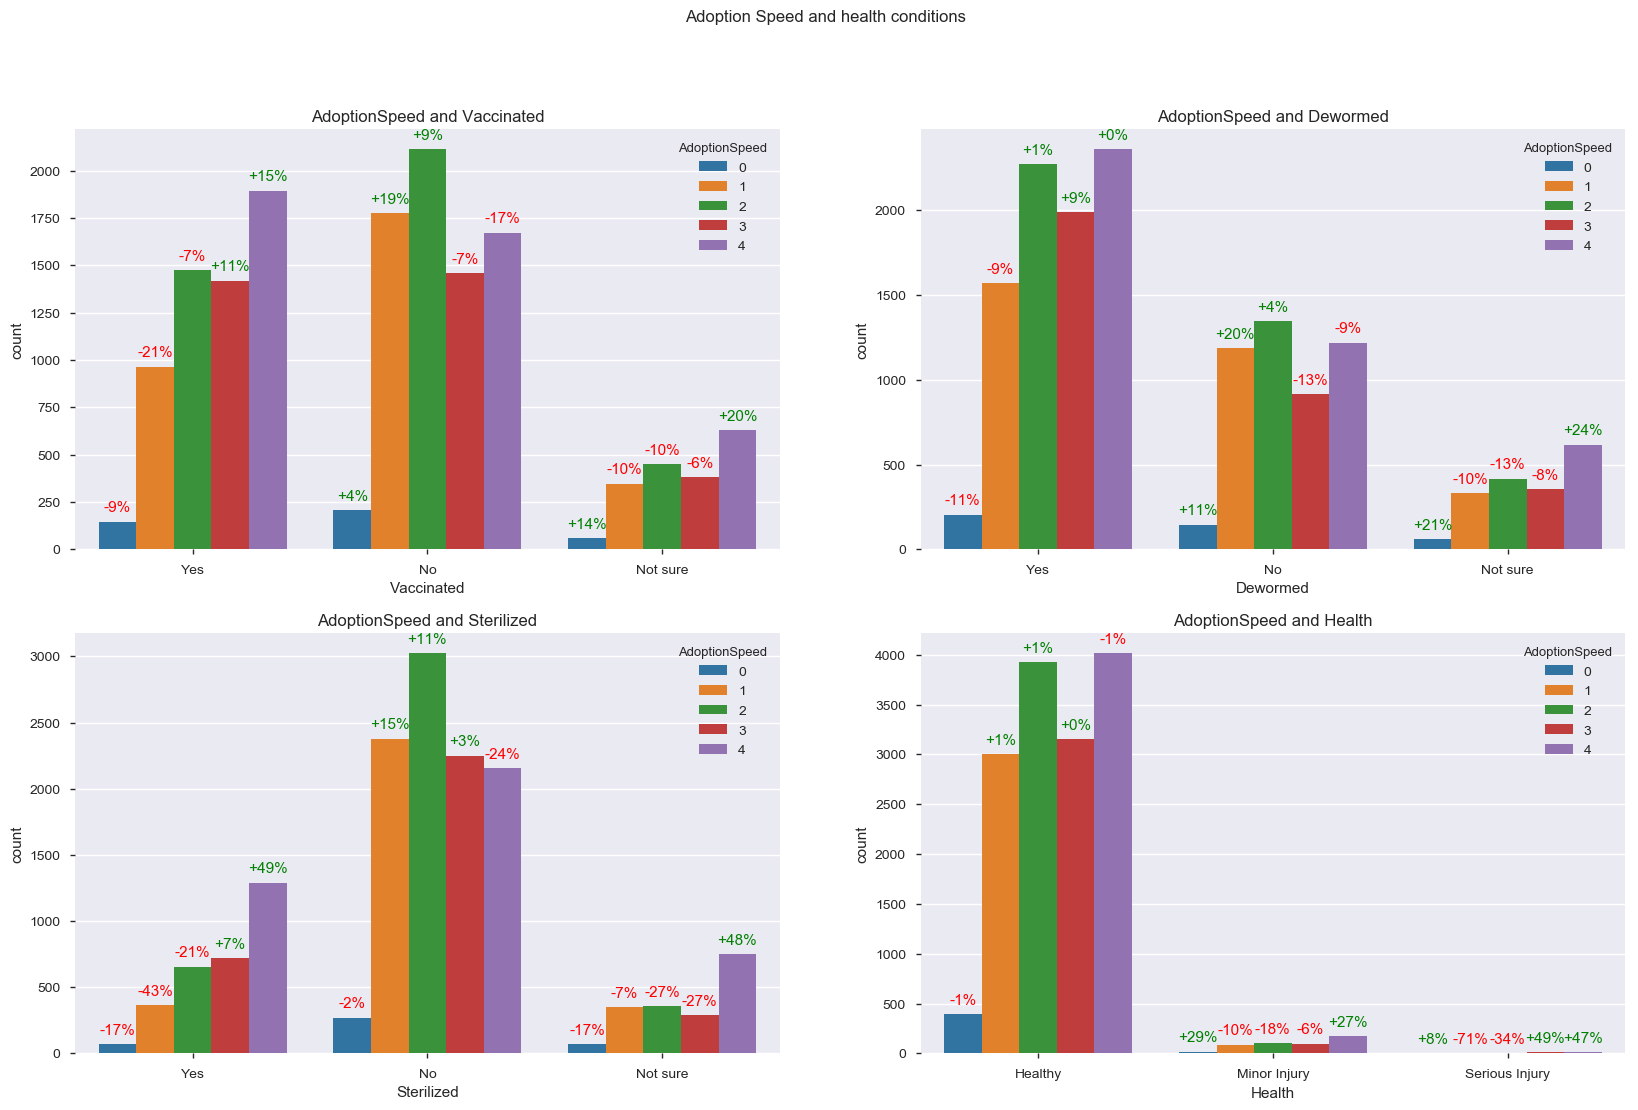

In [132]:
## Plotting vaccinated, dewormed, sterilized and Health for Training

plt.figure(figsize=(20, 12));
plt.subplot(2, 2, 1)
make_count_plot(df=train, x='Vaccinated', title='Vaccinated')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Vaccinated');

plt.subplot(2, 2, 2)
make_count_plot(df=train, x='Dewormed', title='Dewormed')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Dewormed');

plt.subplot(2, 2, 3)
make_count_plot(df=train, x='Sterilized', title='Sterilized')
plt.xticks([0, 1, 2], ['Yes', 'No', 'Not sure']);
plt.title('AdoptionSpeed and Sterilized');

plt.subplot(2, 2, 4)
make_count_plot(df=train, x='Health', title='Health')
plt.xticks([0, 1, 2], ['Healthy', 'Minor Injury', 'Serious Injury']);
plt.title('AdoptionSpeed and Health');

plt.suptitle('Adoption Speed and health conditions');

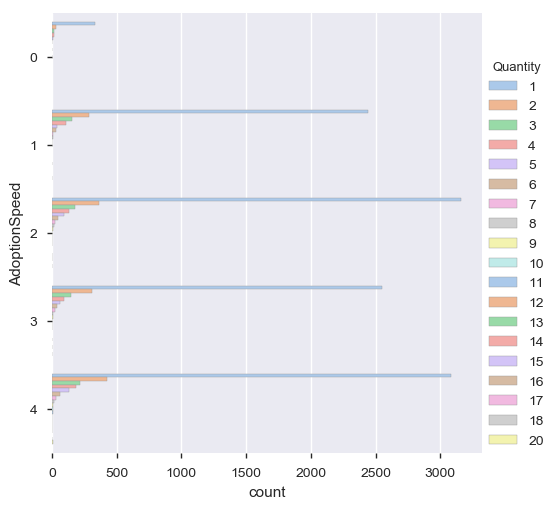

In [133]:
## Barplot and Countplot in Seaborn for Quantity and AS
sns.catplot(y="AdoptionSpeed", 
            hue="Quantity", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [134]:
## Creating another binned category for Quantity
data_r2["Quantity_t"]=data_r2["Quantity"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength     ...      State  AdoptionSpeed  AdoptionSpeed_t  \
0          1     ...      41326              2                0   

   AdoptionSpeed_t2     Age_t   Age_b  Age_bin  Breed1_t  Fee_t  Quantity_t  
0                 0  0.477121  (2, 3]        3       275      1           1  

[1 rows x 26 columns]

In [135]:
## Binnng the all values that have counts for 1 and greater than 1
data_r2.Quantity_t[data_r2.Quantity_t >= 2] = 2
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength     ...      State  AdoptionSpeed  AdoptionSpeed_t  \
0          1     ...      41326              2                0   

   AdoptionSpeed_t2     Age_t   Age_b  Age_bin  Breed1_t  Fee_t  Quantity_t  
0                 0  0.477121  (2, 3]        3       275      1           1  

[1 rows x 26 columns]

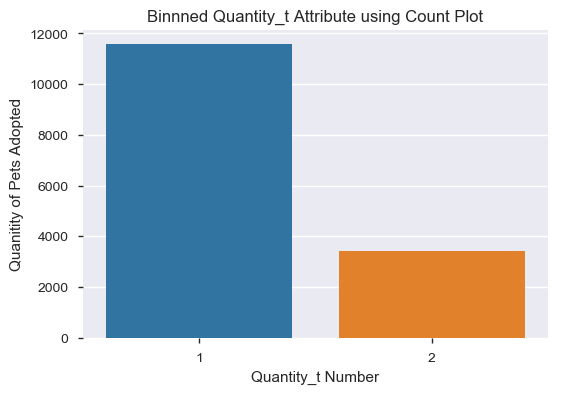

In [136]:
## Plotting Results from Binned Quantity 
plt.figure(figsize=(6, 4));
ax = sns.countplot('Quantity_t', data=data_r2)
ax.set_title('Binnned Quantity_t Attribute using Count Plot')
ax.set_xlabel('Quantity_t Number')
ax.set_ylabel('Quanitity of Pets Adopted')

plt.show()

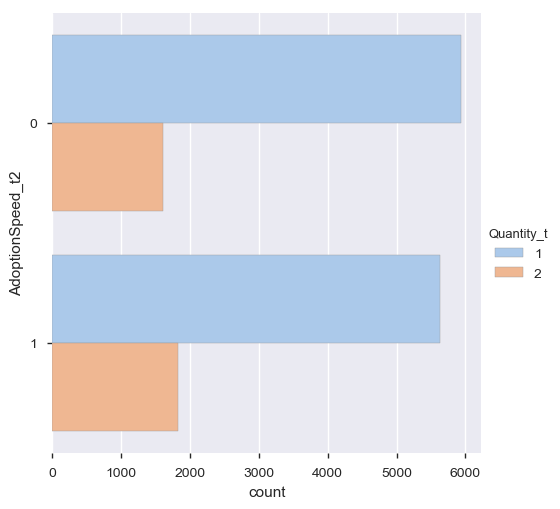

In [137]:
## Barplot and Countplot in Seaborn with Quantity_t and AS_t2
sns.catplot(y="AdoptionSpeed_t2", 
            hue="Quantity_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

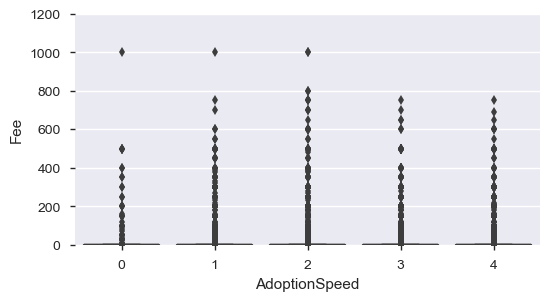

In [138]:
## Box and Whiskerplot for Fee and AS
count, ax = plt.subplots(figsize=(6,3))
fig = sns.boxplot(x='AdoptionSpeed', y="Fee", data=data_r2)
fig.axis(ymin=0, ymax=1200);

In [139]:
## Graphing the fee for the test and training dataset

train['Free'] = train['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
test['Free'] = test['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
all_data['Free'] = all_data['Fee'].apply(lambda x: 'Free' if x == 0 else 'Not Free')
plot_four_graphs(col='Free', main_title='Free', dataset_title='Number of pets by Free in train and test data')

NameError: name 'plot_four_graphs' is not defined

In [ ]:
## Plotting the Fee values less than 400 and Type
plt.figure(figsize=(16, 6));
plt.subplot(1, 2, 1)
plt.hist(train.loc[train['Fee'] < 400, 'Fee']);
plt.title('Distribution of fees lower than 400');

plt.subplot(1, 2, 2)
sns.violinplot(x="AdoptionSpeed", y="Fee", hue="Type", data=train);
plt.title('AdoptionSpeed by Type and Fee');

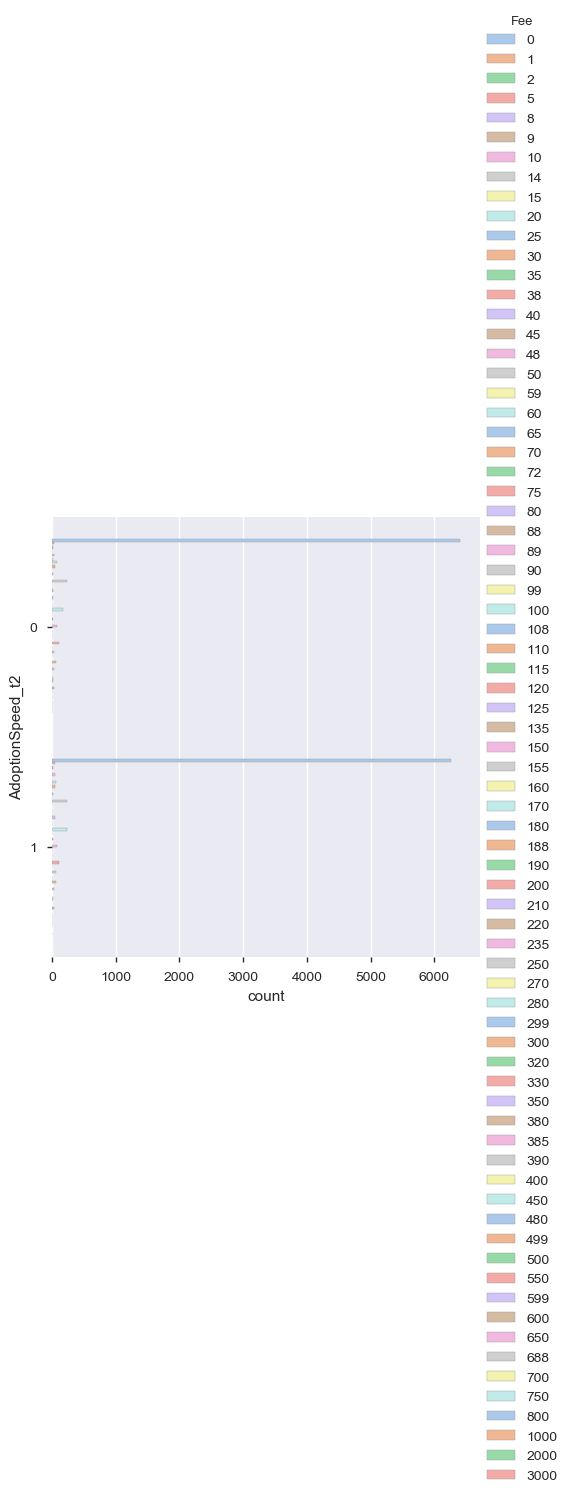

In [140]:
## Barplot and Countplot in Seaborn for Fee and AS_t2
sns.catplot(y="AdoptionSpeed_t2", 
            hue="Fee", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

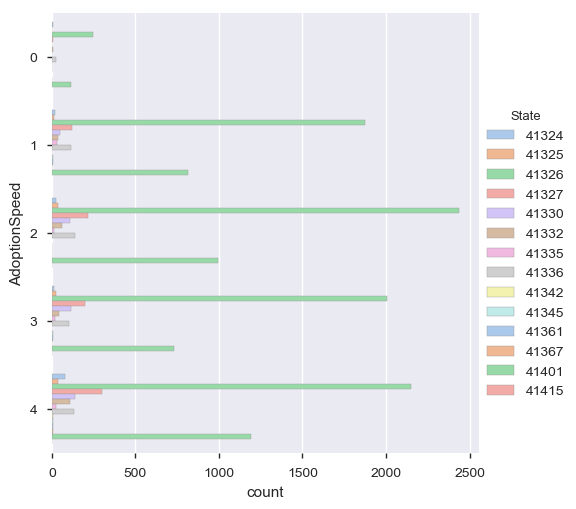

In [141]:
## Barplot and Countplot in Seaborn for State and AS
sns.catplot(y="AdoptionSpeed", 
            hue="State", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

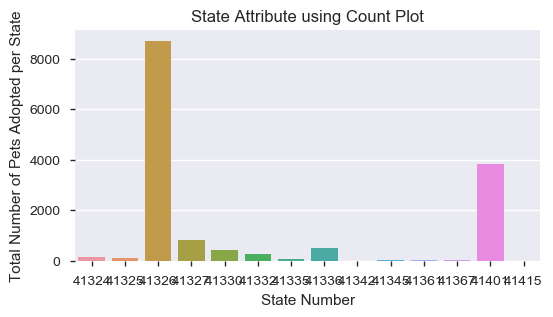

In [142]:
## Count plot for State attribute

count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('State', data=data_r2)
ax.set_title('State Attribute using Count Plot')
ax.set_xlabel('State Number')
ax.set_ylabel('Total Number of Pets Adopted per State')

plt.show()

In [143]:
# Cross Tabulation for Categorical Variables state and AS

pd.crosstab(data_r2.AdoptionSpeed, data_r2.State, margins=True)

State          41324  41325  41326  41327  41330  41332  41335  41336  41342  \
AdoptionSpeed                                                                  
0                  4      3    246      8      3      4      3     23      1   
1                 18     14   1877    122     48     36     29    113      1   
2                 23     34   2435    216    111     63     14    136      0   
3                 12     23   2004    197    117     42     16    103      2   
4                 80     36   2152    300    141    108     23    132      9   
All              137    110   8714    843    420    253     85    507     13   

State          41345  41361  41367  41401  41415    All  
AdoptionSpeed                                            
0                  1      0      2    112      0    410  
1                  6      9      3    814      0   3090  
2                  3      2      3    996      1   4037  
3                  4      6      1    731      1   3259  
4                  8      9      6   1192      1   4197  
All               22     26     15   3845      3  14993

In [144]:
## Value Counts for the State
data_r2['State'].value_counts(normalize=True).head()

41326    0.581205
41401    0.256453
41327    0.056226
41336    0.033816
41330    0.028013
Name: State, dtype: float64

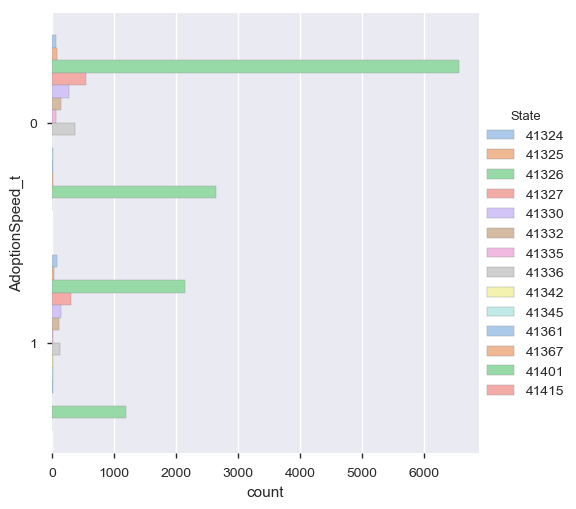

In [145]:
## Barplot and Countplot in Seaborn for State and AS_1
sns.catplot(y="AdoptionSpeed_t", 
            hue="State", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [146]:
## Binning the State Variable
data_r2["State_t"]=data_r2["State"]
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength   ...     AdoptionSpeed  AdoptionSpeed_t  AdoptionSpeed_t2  \
0          1   ...                 2                0                 0   

      Age_t   Age_b  Age_bin  Breed1_t  Fee_t  Quantity_t  State_t  
0  0.477121  (2, 3]        3       275      1           1    41326  

[1 rows x 27 columns]

In [147]:
## Binnng the all values for Sate to have three unique bins
data_r2.State_t[data_r2.State_t == 41324] = 41000
data_r2.State_t[data_r2.State_t == 41325] = 41000
data_r2.State_t[data_r2.State_t == 41327] = 41000
data_r2.State_t[data_r2.State_t == 41330] = 41000
data_r2.State_t[data_r2.State_t == 41332] = 41000
data_r2.State_t[data_r2.State_t == 41335] = 41000
data_r2.State_t[data_r2.State_t == 41336] = 41000
data_r2.State_t[data_r2.State_t == 41342] = 41000
data_r2.State_t[data_r2.State_t == 41345] = 41000
data_r2.State_t[data_r2.State_t == 41361] = 41000
data_r2.State_t[data_r2.State_t == 41367] = 41000
data_r2.State_t[data_r2.State_t == 41415] = 41000
 
data_r2.head(1)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   

   FurLength   ...     AdoptionSpeed  AdoptionSpeed_t  AdoptionSpeed_t2  \
0          1   ...                 2                0                 0   

      Age_t   Age_b  Age_bin  Breed1_t  Fee_t  Quantity_t  State_t  
0  0.477121  (2, 3]        3       275      1           1    41326  

[1 rows x 27 columns]

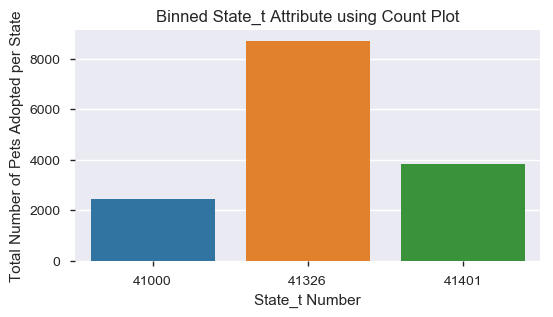

In [148]:
## Count plot for binned State
count, ax = plt.subplots(figsize=(6,3))
ax = sns.countplot('State_t', data=data_r2)
ax.set_title('Binned State_t Attribute using Count Plot')
ax.set_xlabel('State_t Number')
ax.set_ylabel('Total Number of Pets Adopted per State')

plt.show()

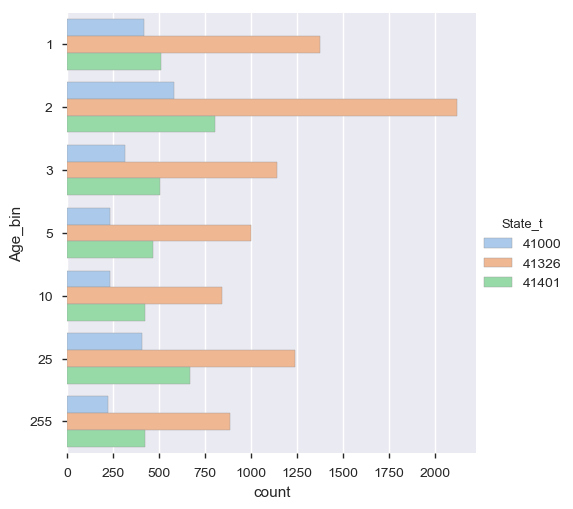

In [149]:
## Barplot and Countplot in Seaborn for State_t and Age_bin
sns.catplot(y="Age_bin", 
            hue="State_t", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=data_r2);

In [150]:
## Saving to CSV File
submit=pd.DataFrame(data=data_r2)
submit.to_csv('05oct_A.csv',index=True)

In [151]:
## Calling the csv file
data_r = pd.read_csv('C:/Users/jlpar/Documents/Springboard Curriculum/Data/petadoption/petfinder-adoption-prediction/05oct_a.csv')
data_r2.head(3)

Type  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  MaturitySize  \
0     2    3     299       0       1       1       7       0             1   
1     2    1     265       0       1       1       2       0             2   
2     1    1     307       0       1       2       7       0             2   

   FurLength   ...     AdoptionSpeed  AdoptionSpeed_t  AdoptionSpeed_t2  \
0          1   ...                 2                0                 0   
1          2   ...                 0                0                 0   
2          2   ...                 3                0                 1   

      Age_t   Age_b  Age_bin  Breed1_t  Fee_t  Quantity_t  State_t  
0  0.477121  (2, 3]        3       275      1           1    41326  
1  0.000000  (0, 1]        1       275      0           1    41401  
2  0.000000  (0, 1]        1       307      0           1    41326  

[3 rows x 27 columns]

In [152]:
################################## Correlations

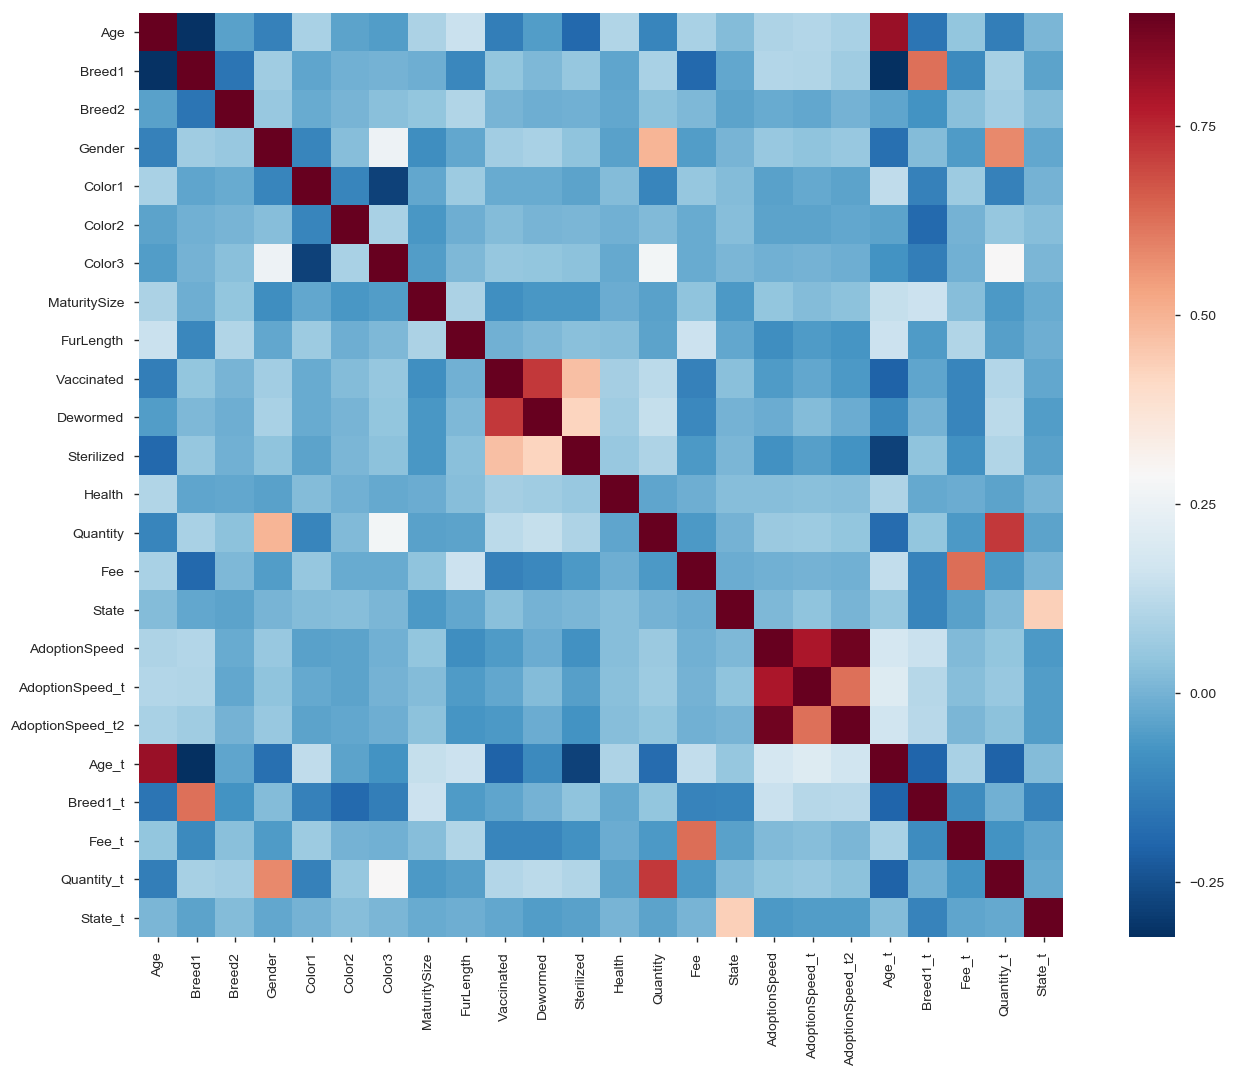

In [153]:
## The correlations between dependent variable and independent variables for all numerical datapoints
## correlation matrix
corr2 = data_r2.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(17, 12))
sns.heatmap(corr2, vmax = 0.9, cmap = 'RdBu_r', square = True)
plt.show()

In [154]:
# The correlations between dependent variable and independent variables for all numerical datapoints

corr2 = data_r2.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()

## rank the correlation
corr_price = corr2['AdoptionSpeed']
corr_df = pd.DataFrame({'Column': corr_price.index, 
                        'Correlation': corr_price,
                        'Abs Value': abs(corr_price)}, index = None)
corr_df = corr_df.drop(['AdoptionSpeed'], axis = 0)
corr_df.set_index('Column', inplace = True)
corr_df = corr_df.rename_axis(None)
corr_df = corr_df.sort_values(by = ['Abs Value'], ascending = [False])
corr_df.iloc[:, 1:2]

Abs Value
AdoptionSpeed_t2   0.884132
AdoptionSpeed_t    0.785748
Age_t              0.183133
Breed1_t           0.150560
Breed1             0.107834
Age                0.100510
FurLength          0.091337
Sterilized         0.083447
Quantity           0.062931
State_t            0.062579
Vaccinated         0.059043
Gender             0.057622
Quantity_t         0.048789
MaturitySize       0.045653
Color1             0.044192
Color2             0.038579
Health             0.029382
Fee_t              0.019344
Breed2             0.018642
Dewormed           0.013210
State              0.013119
Color3             0.007014
Fee                0.004017

In [155]:
## Correlations Matrix with values
data_r2.corr()

Type       Age    Breed1    Breed2    Gender    Color1  \
Type              1.000000 -0.147162  0.057724 -0.043568  0.060843  0.097680   
Age              -0.147162  1.000000 -0.314346 -0.041010 -0.123423  0.090378   
Breed1            0.057724 -0.314346  1.000000 -0.157053  0.071321 -0.035510   
Breed2           -0.043568 -0.041010 -0.157053  1.000000  0.056907 -0.020324   
Gender            0.060843 -0.123423  0.071321  0.056907  1.000000 -0.115351   
Color1            0.097680  0.090378 -0.035510 -0.020324 -0.115351  1.000000   
Color2            0.246333 -0.039427 -0.007081  0.003015  0.026507 -0.113290   
Color3            0.201693 -0.053546 -0.000682  0.035679  0.259309 -0.282897   
MaturitySize     -0.171811  0.093673 -0.010507  0.049879 -0.091819 -0.029468   
FurLength         0.003036  0.153092 -0.108059  0.106220 -0.030404  0.066967   
Vaccinated        0.102907 -0.136061  0.046518  0.005638  0.078702 -0.017475   
Dewormed          0.025508 -0.053360  0.013216 -0.009817  0.091431 -0.019318   
Sterilized        0.006737 -0.189450  0.052698 -0.005989  0.040645 -0.037050   
Health           -0.006864  0.103215 -0.034893 -0.029285 -0.045177  0.024410   
Quantity          0.036423 -0.113076  0.090194  0.038125  0.494489 -0.116688   
Fee              -0.042134  0.089168 -0.189526  0.013508 -0.050491  0.054180   
State             0.124549  0.024523 -0.026832 -0.037993  0.002564  0.024012   
AdoptionSpeed    -0.091240  0.100510  0.107834 -0.018642  0.057622 -0.044192   
AdoptionSpeed_t  -0.041032  0.110439  0.102662 -0.028090  0.043473 -0.024673   
AdoptionSpeed_t2 -0.085406  0.092891  0.071457 -0.001286  0.058508 -0.038220   
Age_t            -0.092682  0.815327 -0.322320 -0.035530 -0.174045  0.131793   
Breed1_t         -0.667153 -0.155538  0.624047 -0.075773  0.023066 -0.121930   
Fee_t             0.026887  0.048670 -0.099961  0.035425 -0.055227  0.065127   
Quantity_t        0.111353 -0.134733  0.085993  0.076282  0.582162 -0.126385   
State_t           0.106546  0.010435 -0.040573  0.022137 -0.027124  0.000335   

                    Color2    Color3  MaturitySize  FurLength    ...     \
Type              0.246333  0.201693     -0.171811   0.003036    ...      
Age              -0.039427 -0.053546      0.093673   0.153092    ...      
Breed1           -0.007081 -0.000682     -0.010507  -0.108059    ...      
Breed2            0.003015  0.035679      0.049879   0.106220    ...      
Gender            0.026507  0.259309     -0.091819  -0.030404    ...      
Color1           -0.113290 -0.282897     -0.029468   0.066967    ...      
Color2            1.000000  0.088742     -0.065155  -0.008764    ...      
Color3            0.088742  1.000000     -0.051730   0.013581    ...      
MaturitySize     -0.065155 -0.051730      1.000000   0.095142    ...      
FurLength        -0.008764  0.013581      0.095142   1.000000    ...      
Vaccinated        0.026193  0.054053     -0.087722  -0.006010    ...      
Dewormed          0.005812  0.048617     -0.067352   0.016463    ...      
Sterilized        0.007370  0.038899     -0.066321   0.032092    ...      
Health           -0.004307 -0.024782     -0.012957   0.028096    ...      
Quantity          0.019876  0.272548     -0.042832  -0.038388    ...      
Fee              -0.017308 -0.019839      0.041144   0.159693    ...      
State             0.026944  0.010554     -0.062584  -0.029317    ...      
AdoptionSpeed    -0.038579 -0.007014      0.045653  -0.091337    ...      
AdoptionSpeed_t  -0.036686  0.000508      0.022822  -0.055806    ...      
AdoptionSpeed_t2 -0.028916 -0.008506      0.039174  -0.073389    ...      
Age_t            -0.038536 -0.075977      0.141797   0.157857    ...      
Breed1_t         -0.187955 -0.131676      0.155775  -0.056738    ...      
Fee_t             0.000456 -0.005990      0.030418   0.105644    ...      
Quantity_t        0.054038  0.292599     -0.061722  -0.048925    ...      
State_t           0.029593  0.009064     -0.018812  -0.007253    .

In [156]:
## Selecting only the two attributes
data_corr=data_r2[["Vaccinated", "Dewormed"]]

In [157]:
## Correlations Matrix with values for vaccinated and Dewormed
data_corr.corr()

Vaccinated  Dewormed
Vaccinated    1.000000  0.722596
Dewormed      0.722596  1.000000

In [158]:
## Anovas Tables for the top attributes selected for this study

In [159]:
## Stats Models for select attributes
print(stats.normaltest(data_r2['AdoptionSpeed'], axis=0))

NormaltestResult(statistic=8103.596911855624, pvalue=0.0)


In [160]:
## Stats Model Results
results = ols('AdoptionSpeed ~ C(Age)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     8.274
Date:                Tue, 08 Oct 2019   Prob (F-statistic):          2.10e-116
Time:                        04:43:21   Log-Likelihood:                -23295.
No. Observations:               14993   AIC:                         4.680e+04
Df Residuals:                   14887   BIC:                         4.761e+04
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.2291      0.086     25.969      0.000       2.061       2.397
C(Age)[T.1]      -0.0363      0.089     -0.408      0.683      -0.211       0.138
C(Age)[T.2]       0.0359      0.088      0.408      0.684      -0.137       0.208
C(Age)[T.3]       0.2297      0.090      2.563      0.010       0.054       0.405
C(Age)[T.4]       0.4012      0.093      4.338      0.000       0.220       0.583
C(Age)[T.5]       0.4651      0.098      4.751      0.000       0.273       0.657
C(Age)[T.6]       0.5720      0.099      5.799      0.000       0.379       0.765
C(Age)[T.7]       0.5717      0.110      5.205      0.000       0.356       0.787
C(Age)[T.8]       0.7030      0.108      6.517      0.000       0.492       0.914
C(Age)[T.9]       0.5481      0.121      4.546      0.000       0.312       0.784
C(Age)[T.10]      0.5240      0.125      4.208      0.000       0.280       0.768
C(Age)[T.11]      0.8348      0.146      5.707      0.000       0.548       1.122
C(Age)[T.12]      0.6541      0.093      7.000      0.000       0.471       0.837
C(Age)[T.13]      0.4959      0.201      2.469      0.014       0.102       0.890
C(Age)[T.14]      0.6525      0.157      4.150      0.000       0.344       0.961
C(Age)[T.15]      0.4545      0.155      2.930      0.003       0.150       0.759
C(Age)[T.16]      0.6909      0.184      3.761      0.000       0.331       1.051
C(Age)[T.17]      0.5620      0.164      3.417      0.001       0.240       0.884
C(Age)[T.18]      0.4194      0.124      3.384      0.001       0.177       0.662
C(Age)[T.19]      0.4248      0.241      1.763      0.078      -0.048       0.897
C(Age)[T.20]      0.5209      0.220      2.364      0.018       0.089       0.953
C(Age)[T.21]      0.8067      0.233      3.456      0.001       0.349       1.264
C(Age)[T.22]      0.5604      0.277      2.023      0.043       0.017       1.104
C(Age)[T.23]      0.3959      0.415      0.954      0.340      -0.417       1.209
C(Age)[T.24]      0.6481      0.097      6.687      0.000       0.458       0.838
C(Age)[T.25]      0.6709      0.373      1.798      0.072      -0.060       1.402
C(Age)[T.26]      1.2325      0.330      3.736      0.000       0.586       1.879
C(Age)[T.27]      0.6533      0.291      2.242      0.025       0.082       1.225
C(Age)[T.28]      0.2325      0.330      0.705      0.481      -0.414       0.879
C(Age)[T.29]      0.7309      0.245      2.981      0.003       0.250       1.212
C(Age)[T.30]      0.3094      0.181      1.710      0.087      -0.045       0.664
C(Age)[T.31]      1.1043      0.392      2.815      0.005       0.335       1.873
C(Age)[T.32]      0.2376      0.309      0.770      0.441      -0.367       0.843
C(Age)[T.33]      0.7709      0.581      1.328      0.184      -0.367       1.909
C(Age)[T.34]      0.9709      0.521      1.865   

In [161]:
## Tukey and Multicomparison Models
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Age'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  0      1    -0.0363  -0.4221   0.3494 False 
  0      2     0.0359  -0.3451   0.4169 False 
  0      3     0.2297  -0.1584   0.6179 False 
  0      4     0.4012   0.0008   0.8017  True 
  0      5     0.4651   0.0412   0.8889  True 
  0      6     0.572    0.1449   0.9991  True 
  0      7     0.5717   0.0962   1.0471  True 
  0      8     0.703    0.236     1.17   True 
  0      9     0.5481   0.0262   1.0701  True 
  0      10    0.524   -0.0151   1.0632 False 
  0      11    0.8348   0.2015   1.4681  True 
  0      12    0.6541   0.2495   1.0586  True 
  0      13    0.4959  -0.3736   1.3655 False 
  0      14    0.6525  -0.0282   1.3332 False 
  0      15    0.4545  -0.2171   1.1261 False 
  0      16    0.6909  -0.1044   1.4863 False 
  0      17    0.562   -0.1501   1.2741 False 
  0      18    0.4194  -0.1171   0.956  False 
  0      

In [162]:
## Stats Model Results
results = ols('AdoptionSpeed ~ C(Breed1_t)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     147.6
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           2.93e-94
Time:                        04:43:23   Log-Likelihood:                -23502.
No. Observations:               14993   AIC:                         4.701e+04
Df Residuals:                   14989   BIC:                         4.704e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.2669      0.025     92.006      0.000       2.219       2.315
C(Breed1_t)[T.266]     0.2122      0.031      6.786      0.000       0.151       0.273
C(Breed1_t)[T.275]     0.0405      0.032      1.264      0.206      -0.022       0.103
C(Breed1_t)[T.307]     0.4792      0.029     16.590      0.000       0.423       0.536
==============================================================================
Omnibus:                     6200.155   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              799.039
Skew:                          -0.131   Prob(JB):                    3.10e-174
Kurtosis:                       1.900   Cond. No.                         6.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
## Stats Model for select attribute
results = ols('AdoptionSpeed ~ C(Age_t)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     8.274
Date:                Tue, 08 Oct 2019   Prob (F-statistic):          2.10e-116
Time:                        04:43:24   Log-Likelihood:                -23295.
No. Observations:               14993   AIC:                         4.680e+04
Df Residuals:                   14887   BIC:                         4.761e+04
Df Model:                         105                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           2.2291      0.086     25.969      0.000       2.061       2.397
C(Age_t)[T.0.0]                    -0.0363      0.089     -0.408      0.683      -0.211       0.138
C(Age_t)[T.0.3010299956639812]      0.0359      0.088      0.408      0.684      -0.137       0.208
C(Age_t)[T.0.47712125471966244]     0.2297      0.090      2.563      0.010       0.054       0.405
C(Age_t)[T.0.6020599913279624]      0.4012      0.093      4.338      0.000       0.220       0.583
C(Age_t)[T.0.6989700043360189]      0.4651      0.098      4.751      0.000       0.273       0.657
C(Age_t)[T.0.7781512503836436]      0.5720      0.099      5.799      0.000       0.379       0.765
C(Age_t)[T.0.8450980400142568]      0.5717      0.110      5.205      0.000       0.356       0.787
C(Age_t)[T.0.9030899869919435]      0.7030      0.108      6.517      0.000       0.492       0.914
C(Age_t)[T.0.9542425094393249]      0.5481      0.121      4.546      0.000       0.312       0.784
C(Age_t)[T.1.0]                     0.5240      0.125      4.208      0.000       0.280       0.768
C(Age_t)[T.1.0413926851582251]      0.8348      0.146      5.707      0.000       0.548       1.122
C(Age_t)[T.1.0791812460476249]      0.6541      0.093      7.000      0.000       0.471       0.837
C(Age_t)[T.1.1139433523068367]      0.4959      0.201      2.469      0.014       0.102       0.890
C(Age_t)[T.1.146128035678238]       0.6525      0.157      4.150      0.000       0.344       0.961
C(Age_t)[T.1.1760912590556813]      0.4545      0.155      2.930      0.003       0.150       0.759
C(Age_t)[T.1.2041199826559248]      0.6909      0.184      3.761      0.000       0.331       1.051
C(Age_t)[T.1.2304489213782739]      0.5620      0.164      3.417      0.001       0.240       0.884
C(Age_t)[T.1.255272505103306]       0.4194      0.124      3.384      0.001       0.177       0.662
C(Age_t)[T.1.2787536009528289]      0.4248      0.241      1.763      0.078      -0.048       0.897
C(Age_t)[T.1.3010299956639813]      0.5209      0.220      2.364      0.018       0.089       0.953
C(Age_t)[T.1.3222192947339193]      0.8067      0.233      3.456      0.001       0.349       1.264
C(Age_t)[T.1.3424226808222062]      0.5604      0.277      2.023      0.043       0.017       1.104
C(Age_t)[T.1.3617278360175928]      0.3959      0.415      0.954      0.340      -0.417       1.209
C(Age_t)[T.1.380211241711606]       0.6481      0.097      6.687      0.000       0.458       0.838
C(Age_t)[T.1.3979400086720377]      0.6709      0.373      1.798      0.072      -0.060       1.402
C(Age_t)[T.1.414973347970818]       1.2325      0.330      3.736      0.000       0.586       1.879
C(Age_t)[T.1.4313637641589874]      0.6533      0.291      2.242      0.025       0

In [164]:
## Stats model results
results = ols('Age ~ C(State_t)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.749
Date:                Tue, 08 Oct 2019   Prob (F-statistic):            0.00867
Time:                        04:43:26   Log-Likelihood:                -64733.
No. Observations:               14993   AIC:                         1.295e+05
Df Residuals:                   14990   BIC:                         1.295e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              10.2597      0.368     27.886      0.000       9.538      10.981
C(State_t)[T.41326]    -0.0961      0.416     -0.231      0.817      -0.912       0.720
C(State_t)[T.41401]     0.9682      0.470      2.059      0.039       0.047       1.890
==============================================================================
Omnibus:                    12035.272   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           305519.562
Skew:                           3.764   Prob(JB):                         0.00
Kurtosis:                      23.794   Cond. No.                         5.44
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [165]:
## State models for Breed1_t and AS_t
results = ols('AdoptionSpeed_t ~ C(Breed1_t)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        AdoptionSpeed_t   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     85.39
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           8.91e-55
Time:                        04:43:28   Log-Likelihood:                -9140.6
No. Observations:               14993   AIC:                         1.829e+04
Df Residuals:                   14989   BIC:                         1.832e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1763      0.009     18.647      0.000       0.158       0.195
C(Breed1_t)[T.266]     0.0923      0.012      7.693      0.000       0.069       0.116
C(Breed1_t)[T.275]     0.0723      0.012      5.884      0.000       0.048       0.096
C(Breed1_t)[T.307]     0.1664      0.011     15.013      0.000       0.145       0.188
==============================================================================
Omnibus:                     5276.213   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2907.928
Skew:                           0.953   Prob(JB):                         0.00
Kurtosis:                       1.990   Cond. No.                         6.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [166]:
## Tukey pairwise comparisons
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Breed1_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 265    266    0.2122   0.1318  0.2925  True 
 265    275    0.0405  -0.0418  0.1228 False 
 265    307    0.4792   0.405   0.5534  True 
 266    275   -0.1717  -0.2439 -0.0995  True 
 266    307    0.267    0.2042  0.3298  True 
 275    307    0.4387   0.3734  0.504   True 
---------------------------------------------


In [167]:
## Stat Model for AS and Breed2
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Breed2'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  0      1    -0.5385  -5.7269    4.65  False 
  0      2    -1.5385  -6.7269    3.65  False 
  0      4    -1.5385  -6.7269    3.65  False 
  0      5    -2.0385  -5.7074   1.6305 False 
  0      10   -0.0385  -3.7074   3.6305 False 
  0      14    0.9615  -2.7074   4.6305 False 
  0      16   -1.0385  -4.7074   2.6305 False 
  0      17    1.4615  -3.7269    6.65  False 
  0      18    0.4615  -2.5343   3.4574 False 
  0      19   -0.0385  -3.7074   3.6305 False 
  0      20   -0.6635  -1.9615   0.6345 False 
  0      21    0.7949   -2.201   3.7907 False 
  0      24   -1.5385  -4.5343   1.4574 False 
  0      25   -1.5385  -6.7269    3.65  False 
  0      26   -0.4208  -1.6801   0.8385 False 
  0      36    0.4615  -4.7269    5.65  False 
  0      39    0.007   -1.5581   1.5721 False 
  0      40    0.4615  -4.7269    5.65  False 
  0      

In [168]:
## Pairwise comparison for Breed2 and  AS
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Breed2'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
  0      1    -0.5385  -5.7269    4.65  False 
  0      2    -1.5385  -6.7269    3.65  False 
  0      4    -1.5385  -6.7269    3.65  False 
  0      5    -2.0385  -5.7074   1.6305 False 
  0      10   -0.0385  -3.7074   3.6305 False 
  0      14    0.9615  -2.7074   4.6305 False 
  0      16   -1.0385  -4.7074   2.6305 False 
  0      17    1.4615  -3.7269    6.65  False 
  0      18    0.4615  -2.5343   3.4574 False 
  0      19   -0.0385  -3.7074   3.6305 False 
  0      20   -0.6635  -1.9615   0.6345 False 
  0      21    0.7949   -2.201   3.7907 False 
  0      24   -1.5385  -4.5343   1.4574 False 
  0      25   -1.5385  -6.7269    3.65  False 
  0      26   -0.4208  -1.6801   0.8385 False 
  0      36    0.4615  -4.7269    5.65  False 
  0      39    0.007   -1.5581   1.5721 False 
  0      40    0.4615  -4.7269    5.65  False 
  0      

In [169]:
## STATS model for AS and Sterilized
results = ols('AdoptionSpeed ~ C(Sterilized)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     290.5
Date:                Tue, 08 Oct 2019   Prob (F-statistic):          1.61e-124
Time:                        04:43:38   Log-Likelihood:                -23435.
No. Observations:               14993   AIC:                         4.688e+04
Df Residuals:                   14990   BIC:                         4.690e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.9023      0.021    139.909      0.000       2.862       2.943
C(Sterilized)[T.2]    -0.5406      0.024    -22.788      0.000      -0.587      -0.494
C(Sterilized)[T.3]    -0.1860      0.034     -5.449      0.000      -0.253      -0.119
==============================================================================
Omnibus:                     3404.942   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              704.761
Skew:                          -0.187   Prob(JB):                    9.19e-154
Kurtosis:                       2.006   Cond. No.                         5.36
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [170]:
## Tukey pairwise comparisons for AS and Sterilized 
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Sterilized'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2    -0.5406  -0.5962 -0.485  True 
  1      3     -0.186  -0.2661 -0.106  True 
  2      3     0.3545   0.2855 0.4236  True 
--------------------------------------------


In [171]:
## Stats model for AS and Quantity
results = ols('AdoptionSpeed ~ C(Quantity)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     4.018
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           1.92e-08
Time:                        04:43:41   Log-Likelihood:                -23684.
No. Observations:               14993   AIC:                         4.741e+04
Df Residuals:                   14974   BIC:                         4.755e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.4852      0.011    227.426      0.000       2.464       2.507
C(Quantity)[T.2]      0.0795      0.033      2.408      0.016       0.015       0.144
C(Quantity)[T.3]      0.0493      0.045      1.096      0.273      -0.039       0.137
C(Quantity)[T.4]      0.1495      0.052      2.866      0.004       0.047       0.252
C(Quantity)[T.5]      0.3166      0.065      4.848      0.000       0.189       0.445
C(Quantity)[T.6]      0.2662      0.087      3.057      0.002       0.095       0.437
C(Quantity)[T.7]      0.3482      0.129      2.706      0.007       0.096       0.600
C(Quantity)[T.8]      0.1494      0.163      0.915      0.360      -0.171       0.470
C(Quantity)[T.9]      0.2724      0.205      1.330      0.184      -0.129       0.674
C(Quantity)[T.10]     0.5675      0.270      2.103      0.035       0.039       1.096
C(Quantity)[T.11]     0.8148      0.372      2.192      0.028       0.086       1.544
C(Quantity)[T.12]     0.5148      0.480      1.073      0.283      -0.426       1.455
C(Quantity)[T.13]     0.5148      0.831      0.620      0.536      -1.114       2.144
C(Quantity)[T.14]     1.5148      0.831      1.823      0.068      -0.114       3.144
C(Quantity)[T.15]     0.5148      0.588      0.876      0.381      -0.637       1.667
C(Quantity)[T.16]     0.1815      0.679      0.267      0.789      -1.149       1.512
C(Quantity)[T.17]    -0.1518      0.679     -0.224      0.823      -1.482       1.178
C(Quantity)[T.18]     1.5148      1.175      1.289      0.197      -0.789       3.818
C(Quantity)[T.20]     0.8482      0.339      2.499      0.012       0.183       1.513
==============================================================================
Omnibus:                     7608.334   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              858.045
Skew:                          -0.155   Prob(JB):                    4.76e-187
Kurtosis:                       1.870   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [172]:
## Tukey pairwise comparisons for Quantity and AS
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Quantity'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.0795  -0.0366 0.1957 False 
  1      3     0.0493  -0.1089 0.2074 False 
  1      4     0.1495   -0.034 0.333  False 
  1      5     0.3166   0.0869 0.5464  True 
  1      6     0.2662  -0.0402 0.5725 False 
  1      7     0.3482  -0.1045 0.8009 False 
  1      8     0.1494  -0.4251 0.724  False 
  1      9     0.2724  -0.4483 0.9931 False 
  1      10    0.5675  -0.3817 1.5166 False 
  1      11    0.8148   -0.493 2.1227 False 
  1      12    0.5148  -1.1733 2.203  False 
  1      13    0.5148  -2.4086 3.4383 False 
  1      14    1.5148  -1.4086 4.4383 False 
  1      15    0.5148  -1.5525 2.5822 False 
  1      16    0.1815  -2.2056 2.5686 False 
  1      17   -0.1518  -2.5389 2.2352 False 
  1      18    1.5148  -2.6193 5.649  False 
  1      20    0.8482  -0.3458 2.0422 False 
  2      3    -0.0303  -0.2188 0.1583 False 
  2 

In [173]:
## Stats model for State and AS
results = ols('AdoptionSpeed ~ C(State)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     12.71
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           2.51e-28
Time:                        04:43:42   Log-Likelihood:                -23638.
No. Observations:               14993   AIC:                         4.730e+04
Df Residuals:                   14979   BIC:                         4.741e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.0657      0.100     30.634      0.000       2.870       3.262
C(State)[T.41325]    -0.3839      0.150     -2.560      0.010      -0.678      -0.090
C(State)[T.41326]    -0.6137      0.101     -6.084      0.000      -0.811      -0.416
C(State)[T.41327]    -0.2840      0.108     -2.632      0.009      -0.495      -0.072
C(State)[T.41330]    -0.2443      0.115     -2.120      0.034      -0.470      -0.018
C(State)[T.41332]    -0.2198      0.124     -1.769      0.077      -0.463       0.024
C(State)[T.41335]    -0.7480      0.162     -4.625      0.000      -1.065      -0.431
C(State)[T.41336]    -0.6554      0.113     -5.811      0.000      -0.877      -0.434
C(State)[T.41342]     0.2420      0.340      0.712      0.477      -0.424       0.908
C(State)[T.41345]    -0.5202      0.269     -1.934      0.053      -1.048       0.007
C(State)[T.41361]    -0.4888      0.251     -1.951      0.051      -0.980       0.002
C(State)[T.41367]    -0.6657      0.319     -2.090      0.037      -1.290      -0.041
C(State)[T.41401]    -0.5255      0.102     -5.160      0.000      -0.725      -0.326
C(State)[T.41415]    -0.0657      0.684     -0.096      0.923      -1.406       1.274
==============================================================================
Omnibus:                     6821.652   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              835.702
Skew:                          -0.155   Prob(JB):                    3.39e-182
Kurtosis:                       1.886   Cond. No.                         86.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
## Stats model for Color1 and AS
results = ols('AdoptionSpeed ~ C(Color1)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     9.319
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           3.17e-10
Time:                        04:43:43   Log-Likelihood:                -23692.
No. Observations:               14993   AIC:                         4.740e+04
Df Residuals:                   14986   BIC:                         4.745e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5336      0.014    185.777      0.000       2.507       2.560
C(Color1)[T.2]     0.0507      0.024      2.152      0.031       0.005       0.097
C(Color1)[T.3]    -0.1207      0.041     -2.977      0.003      -0.200      -0.041
C(Color1)[T.4]     0.0358      0.049      0.736      0.462      -0.060       0.131
C(Color1)[T.5]    -0.1818      0.042     -4.347      0.000      -0.264      -0.100
C(Color1)[T.6]    -0.1520      0.047     -3.237      0.001      -0.244      -0.060
C(Color1)[T.7]    -0.1363      0.048     -2.869      0.004      -0.229      -0.043
==============================================================================
Omnibus:                     7444.052   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              853.477
Skew:                          -0.154   Prob(JB):                    4.67e-186
Kurtosis:                       1.873   Cond. No.                         5.95
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [175]:
## Tukey pairwise comparison
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Color1'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2     0.0507  -0.0188  0.1201 False 
  1      3    -0.1207  -0.2403 -0.0011  True 
  1      4     0.0358  -0.1076  0.1792 False 
  1      5    -0.1818  -0.3051 -0.0585  True 
  1      6     -0.152  -0.2905 -0.0135  True 
  1      7    -0.1363  -0.2764  0.0038 False 
  2      3    -0.1714  -0.2974 -0.0453  True 
  2      4    -0.0149  -0.1637  0.134  False 
  2      5    -0.2325   -0.362 -0.1029  True 
  2      6    -0.2027  -0.3468 -0.0586  True 
  2      7     -0.187  -0.3326 -0.0413  True 
  3      4     0.1565  -0.0213  0.3344 False 
  3      5    -0.0611  -0.2232  0.101  False 
  3      6    -0.0313  -0.2052  0.1426 False 
  3      7    -0.0156  -0.1908  0.1596 False 
  4      5    -0.2176   -0.398 -0.0372  True 
  4      6    -0.1878  -0.3789  0.0032 False 
  4      7    -0.1721  -0.3643  0.0201 False 
  5      6     0.0298  -0.146

In [176]:
## STATS model for Color2 and AS
results = ols('AdoptionSpeed ~ C(Color2)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.575
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           5.96e-07
Time:                        04:43:43   Log-Likelihood:                -23701.
No. Observations:               14993   AIC:                         4.742e+04
Df Residuals:                   14986   BIC:                         4.747e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.5567      0.018    145.376      0.000       2.522       2.591
C(Color2)[T.2]     0.0011      0.027      0.041      0.967      -0.052       0.054
C(Color2)[T.3]    -0.0356      0.048     -0.749      0.454      -0.129       0.058
C(Color2)[T.4]     0.0456      0.044      1.046      0.295      -0.040       0.131
C(Color2)[T.5]    -0.1125      0.039     -2.872      0.004      -0.189      -0.036
C(Color2)[T.6]    -0.1832      0.040     -4.566      0.000      -0.262      -0.105
C(Color2)[T.7]    -0.0872      0.027     -3.271      0.001      -0.140      -0.035
==============================================================================
Omnibus:                     7942.342   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              865.551
Skew:                          -0.153   Prob(JB):                    1.12e-188
Kurtosis:                       1.863   Cond. No.                         6.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
## Tukey Pariwise comparison for Color2 and AS
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Color2'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      2     0.0011  -0.0784  0.0806 False 
  0      3    -0.0356  -0.1757  0.1045 False 
  0      4     0.0456  -0.0829  0.1741 False 
  0      5    -0.1125  -0.2281  0.003  False 
  0      6    -0.1832  -0.3016 -0.0649  True 
  0      7    -0.0872  -0.1659 -0.0086  True 
  2      3    -0.0367  -0.1801  0.1067 False 
  2      4     0.0445  -0.0876  0.1766 False 
  2      5    -0.1137  -0.2332  0.0059 False 
  2      6    -0.1843  -0.3066 -0.0621  True 
  2      7    -0.0883  -0.1728 -0.0039  True 
  3      4     0.0812  -0.0942  0.2565 False 
  3      5     -0.077  -0.2431  0.0891 False 
  3      6    -0.1477  -0.3157  0.0204 False 
  3      7    -0.0517  -0.1946  0.0913 False 
  4      5    -0.1581  -0.3146 -0.0017  True 
  4      6    -0.2288  -0.3874 -0.0703  True 
  4      7    -0.1328  -0.2644 -0.0012  True 
  5      6    -0.0707  -0.218

In [178]:
## STATS model for Gender and AS
results = ols('AdoptionSpeed ~ C(Gender)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     30.52
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           5.91e-14
Time:                        04:43:44   Log-Likelihood:                -23690.
No. Observations:               14993   AIC:                         4.739e+04
Df Residuals:                   14990   BIC:                         4.741e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.4187      0.016    153.166      0.000       2.388       2.450
C(Gender)[T.2]     0.1512      0.021      7.214      0.000       0.110       0.192
C(Gender)[T.3]     0.1675      0.030      5.639      0.000       0.109       0.226
==============================================================================
Omnibus:                     7300.711   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              849.911
Skew:                          -0.155   Prob(JB):                    2.78e-185
Kurtosis:                       1.876   Cond. No.                         3.99
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [179]:
## Tukey Pairwise comparison of the means 
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Gender'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2     0.1512   0.102  0.2003  True 
  1      3     0.1675   0.0979 0.2372  True 
  2      3     0.0164  -0.0509 0.0836 False 
--------------------------------------------


In [180]:
## STATS Model for Type and AS
results = ols('AdoptionSpeed ~ C(Type)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     125.8
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           4.34e-29
Time:                        04:43:44   Log-Likelihood:                -23658.
No. Observations:               14993   AIC:                         4.732e+04
Df Residuals:                   14991   BIC:                         4.733e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.6151      0.013    201.147      0.000       2.590       2.641
C(Type)[T.2]    -0.2156      0.019    -11.218      0.000      -0.253      -0.178
==============================================================================
Omnibus:                     7191.790   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              837.816
Skew:                          -0.143   Prob(JB):                    1.18e-182
Kurtosis:                       1.878   Cond. No.                         2.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [181]:
## Tukey pairwise comparison for Type and  AS
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Type'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  1      2    -0.2156  -0.2533 -0.1779  True 
---------------------------------------------


In [182]:
## STATS model for Vaccinated and AS
results = ols('AdoptionSpeed ~ C(Vaccinated)', data=data_r2).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AdoptionSpeed   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     122.9
Date:                Tue, 08 Oct 2019   Prob (F-statistic):           1.11e-53
Time:                        04:43:45   Log-Likelihood:                -23598.
No. Observations:               14993   AIC:                         4.720e+04
Df Residuals:                   14990   BIC:                         4.723e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              2.6701      0.015    175.591      0.000       2.640       2.700
C(Vaccinated)[T.2]    -0.3081      0.020    -15.034      0.000      -0.348      -0.268
C(Vaccinated)[T.3]    -0.0410      0.031     -1.324      0.186      -0.102       0.020
==============================================================================
Omnibus:                     5463.460   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              791.315
Skew:                          -0.160   Prob(JB):                    1.47e-172
Kurtosis:                       1.921   Cond. No.                         4.04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [183]:
## Tukey Pairwise comparison for  Vaccinated and AS
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Vaccinated'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  1      2    -0.3081  -0.3561 -0.26   True 
  1      3     -0.041  -0.1137 0.0316 False 
  2      3     0.267    0.196  0.3381  True 
--------------------------------------------


In [184]:
## Tukey Pairwise comparison for  Vaccinated and AS
mc = MultiComparison(data_r2['AdoptionSpeed'], data_r2['Breed1_t'])
tkresult = mc.tukeyhsd()
 
print(tkresult)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 265    266    0.2122   0.1318  0.2925  True 
 265    275    0.0405  -0.0418  0.1228 False 
 265    307    0.4792   0.405   0.5534  True 
 266    275   -0.1717  -0.2439 -0.0995  True 
 266    307    0.267    0.2042  0.3298  True 
 275    307    0.4387   0.3734  0.504   True 
---------------------------------------------


In [185]:
###################### Creating only a 265 Breed Category for this dataset 

In [186]:
## Selecting all dog breeds except 307
df_breed=data_r[data_r['Breed1'] < 241]
df_breed.describe()

Type          Age       Breed1       Breed2       Gender  \
count  2218.000000  2218.000000  2218.000000  2218.000000  2218.000000   
mean      1.004058    27.197024   141.404418   126.833634     1.611362   
std       0.063585    28.597899    62.359183   139.064377     0.593528   
min       1.000000     0.000000     0.000000     0.000000     1.000000   
25%       1.000000     4.000000   103.000000     0.000000     1.000000   
50%       1.000000    17.000000   141.000000    19.000000     2.000000   
75%       1.000000    42.000000   200.000000   307.000000     2.000000   
max       2.000000   168.000000   240.000000   307.000000     3.000000   

            Color1       Color2      Color3  MaturitySize    FurLength  \
count  2218.000000  2218.000000  2218.00000   2218.000000  2218.000000   
mean      2.402164     2.777277     1.33138      1.901262     1.685753   
std       1.827380     2.729909     2.66329      0.697109     0.698594   
min       1.000000     0.000000     0.00000      1.000000     1.000000   
25%       1.000000     0.000000     0.00000      1.000000     1.000000   
50%       2.000000     2.000000     0.00000      2.000000     2.000000   
75%       3.000000     5.000000     0.00000      2.000000     2.000000   
max       7.000000     7.000000     7.00000      4.000000     3.000000   

           ...              State  AdoptionSpeed  AdoptionSpeed_t  \
count      ...        2218.000000    2218.000000      2218.000000   
mean       ...       41344.925158       2.266907         0.176285   
std        ...          31.943268       1.146860         0.381148   
min        ...       41324.000000       0.000000         0.000000   
25%        ...       41326.000000       1.000000         0.000000   
50%        ...       41326.000000       2.000000         0.000000   
75%        ...       41336.000000       3.000000         0.000000   
max        ...       41415.000000       4.000000         1.000000   

       AdoptionSpeed_t2        Age_t      Age_bin  Breed1_t        Fee_t  \
count       2218.000000  2218.000000  2218.000000    2218.0  2218.000000   
mean           0.432822     1.116140   101.628945     265.0     0.246619   
std            0.495578     0.597591   117.654229       0.0     0.431140   
min            0.000000     0.000000     1.000000     265.0     0.000000   
25%            0.000000     0.602060     5.000000     265.0     0.000000   
50%            0.000000     1.230449    25.000000     265.0     0.000000   
75%            1.000000     1.623249   255.000000     265.0     0.000000   
max            1.000000     2.225309   255.000000     265.0     1.000000   

        Quantity_t       State_t  
count  2218.000000   2218.000000  
mean      1.098287  41297.011722  
std       0.297769    126.142976  
min       1.000000  41000.000000  
25%       1.000000  41326.000000  
50%       1.000000  41326.000000  
75%       1.000000  41326.000000  
max       2.000000  41401.000000  

[8 rows x 26 columns]

In [187]:
## Checking the unique values of State
df_breed.State.unique()

array([41335, 41326, 41327, 41401, 41330, 41325, 41336, 41345, 41324,
       41415, 41361, 41332], dtype=int64)

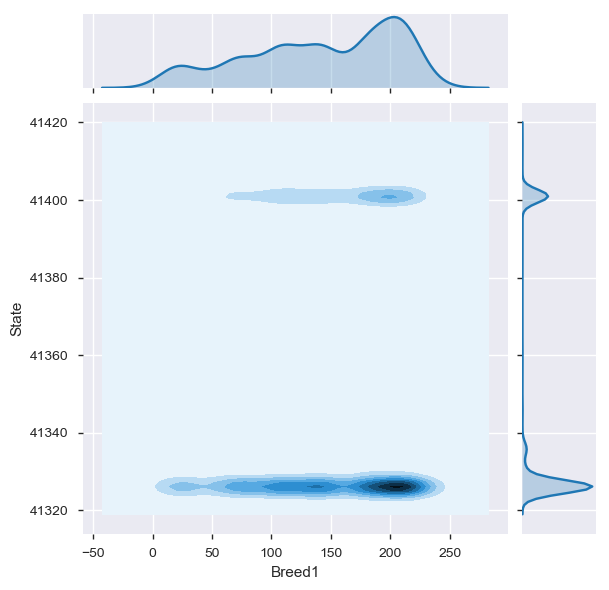

In [188]:
## Creating a kde Plot of the values 
sns.jointplot(x=df_breed["Breed1"], y=df_breed["State"], kind='kde')
plt.show()

In [189]:
# Cross Tabulation for Categorical Variable Breed and State

dff=pd.crosstab(df_breed.Breed1, df_breed.State, margins=True)
dff.head(100)

State   41324  41325  41326  41327  41330  41332  41335  41336  41345  41361  \
Breed1                                                                         
0           0      0      3      0      0      0      0      1      0      0   
1           0      0      1      0      1      0      0      0      0      0   
3           0      0      1      0      0      0      0      0      0      0   
5           0      0      1      0      0      0      0      0      0      0   
7           0      0      0      0      1      0      0      0      0      0   
10          0      0      1      0      0      0      0      0      0      0   
11          0      0      0      0      0      0      0      0      0      0   
15          0      0      1      0      1      0      6      0      1      0   
16          0      0      0      1      0      0      0      0      0      0   
17          0      0      4      0      0      0      0      0      0      0   
18          0      0      6      0      0      0      0      0      0      0   
19          0      0      4      0      0      2      0      0      0      0   
20          0      0     51      6      2      1      0      4      0      0   
21          0      0      0      0      0      0      0      0      0      0   
23          0      0      0      0      0      0      0      0      0      0   
24          0      0      1      0      0      0      0      0      0      0   
25          0      0      1      0      0      0      0      0      0      0   
26          0      0     21      0      1      0      0      1      0      0   
31          0      0      8      0      0      0      0      0      0      0   
32          0      0      2      0      0      0      0      0      0      0   
39          0      1     13      0      2      1      4      0      0      0   
42          0      0      3      0      1      0      0      1      0      0   
44          0      0      7      1      0      0      0      0      0      0   
49          0      0     10      1      0      0      0      0      0      0   
50          0      0      4      1      0      0      0      0      0      0   
56          0      0      1      0      0      0      0      0      0      0   
58          0      0      0      1      0      0      0      0      0      0   
60          0      0     19      9      0      1      0      1      0      0   
61          0      0      1      0      0      0      0      0      0      0   
64          0      0      1      0      0      0      0      0      0      0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
148         0      0      2      0      0      0      0      0      0      0   
150         0      0      2      0      0      0      0      0      0      0   
152         1      1     33      3      2      0      0      1      0      0   
154         0      0      0      0      0      0      0      0      0      0   
155         0      0      0      0      0      0      0      0      0      0   
165         0      0      1      0      0      0      0      0      0      0   
167         0      0      2      0      0      0      0      0      0      0   
169         0      0     13      1      0      0      0      0      1      0   
173         0      0     14      0      0      1      1      2      0      0   
176         0      0      0      0      0      0      0      0      0      0   
178         0      0     13      0      1      1      0      0      0      0   
179         5      1     96     10      9      2      0      3      0      1   
182         0      0     14      1      0      0      0      0      0      0   
185         0      0      4      0      0      0      0      0      0      0   
187         0      0      1      0      0      0      0      0      0      0   
188         0      0      1      0      0      0      0      0      0      0   
189         0      0     50      2      6      0      0      4      0      0   


In [190]:
##Saving output
submit=pd.DataFrame(dff)
submit.to_csv('dff.csv',index=True)

In [191]:
## Selecting all dog breeds not 307 and with adoption speed of 0
df2_breed=df_breed[df_breed['AdoptionSpeed_t'] ==0]
df2_breed.describe()

Type          Age       Breed1       Breed2       Gender  \
count  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000   
mean      1.002737    25.669403   142.009852   123.390257     1.609743   
std       0.052256    27.781047    61.828411   138.519861     0.594216   
min       1.000000     0.000000     0.000000     0.000000     1.000000   
25%       1.000000     3.000000   103.000000     0.000000     1.000000   
50%       1.000000    12.000000   141.000000     0.000000     2.000000   
75%       1.000000    36.000000   200.000000   307.000000     2.000000   
max       2.000000   168.000000   240.000000   307.000000     3.000000   

            Color1       Color2       Color3  MaturitySize    FurLength  \
count  1827.000000  1827.000000  1827.000000   1827.000000  1827.000000   
mean      2.380405     2.810619     1.311987      1.891078     1.696223   
std       1.818822     2.724727     2.650938      0.708779     0.705325   
min       1.000000     0.000000     0.000000      1.000000     1.000000   
25%       1.000000     0.000000     0.000000      1.000000     1.000000   
50%       2.000000     2.000000     0.000000      2.000000     2.000000   
75%       3.000000     5.000000     0.000000      2.000000     2.000000   
max       7.000000     7.000000     7.000000      4.000000     3.000000   

           ...              State  AdoptionSpeed  AdoptionSpeed_t  \
count      ...        1827.000000    1827.000000           1827.0   
mean       ...       41344.645868       1.896004              0.0   
std        ...          31.833303       0.903395              0.0   
min        ...       41324.000000       0.000000              0.0   
25%        ...       41326.000000       1.000000              0.0   
50%        ...       41326.000000       2.000000              0.0   
75%        ...       41336.000000       3.000000              0.0   
max        ...       41415.000000       3.000000              0.0   

       AdoptionSpeed_t2        Age_t      Age_bin  Breed1_t        Fee_t  \
count       1827.000000  1827.000000  1827.000000    1827.0  1827.000000   
mean           0.311440     1.076002    96.095238     265.0     0.240285   
std            0.463209     0.606314   116.441857       0.0     0.427373   
min            0.000000     0.000000     1.000000     265.0     0.000000   
25%            0.000000     0.477121     3.000000     265.0     0.000000   
50%            0.000000     1.079181    25.000000     265.0     0.000000   
75%            1.000000     1.556303   255.000000     265.0     0.000000   
max            1.000000     2.225309   255.000000     265.0     1.000000   

        Quantity_t       State_t  
count  1827.000000   1827.000000  
mean      1.095238  41301.471812  
std       0.293624    120.814666  
min       1.000000  41000.000000  
25%       1.000000  41326.000000  
50%       1.000000  41326.000000  
75%       1.000000  41326.000000  
max       2.000000  41401.000000  

[8 rows x 26 columns]

In [192]:
# Cross Tabulation for Categorical Variable Breed and State for AdoptionSpeed of 0

dfff=pd.crosstab(df2_breed.Breed1, df2_breed.State, margins=True)
dfff.head(100)

State   41324  41325  41326  41327  41330  41332  41335  41336  41345  41361  \
Breed1                                                                         
0           0      0      1      0      0      0      0      1      0      0   
5           0      0      0      0      0      0      0      0      0      0   
10          0      0      1      0      0      0      0      0      0      0   
15          0      0      0      0      0      0      6      0      0      0   
17          0      0      2      0      0      0      0      0      0      0   
18          0      0      4      0      0      0      0      0      0      0   
19          0      0      4      0      0      2      0      0      0      0   
20          0      0     44      4      2      1      0      3      0      0   
21          0      0      0      0      0      0      0      0      0      0   
23          0      0      0      0      0      0      0      0      0      0   
24          0      0      1      0      0      0      0      0      0      0   
25          0      0      1      0      0      0      0      0      0      0   
26          0      0     19      0      1      0      0      1      0      0   
31          0      0      7      0      0      0      0      0      0      0   
32          0      0      2      0      0      0      0      0      0      0   
39          0      1     10      0      1      1      4      0      0      0   
42          0      0      3      0      0      0      0      1      0      0   
44          0      0      5      0      0      0      0      0      0      0   
49          0      0      7      1      0      0      0      0      0      0   
50          0      0      3      0      0      0      0      0      0      0   
56          0      0      1      0      0      0      0      0      0      0   
58          0      0      0      1      0      0      0      0      0      0   
60          0      0     17      8      0      0      0      0      0      0   
61          0      0      1      0      0      0      0      0      0      0   
64          0      0      1      0      0      0      0      0      0      0   
65          0      0      1      0      0      0      0      0      0      0   
69          0      0     21      1      2      0      0      2      0      1   
70          0      0     10      0      0      0      0      0      0      0   
71          0      0      2      0      0      0      0      0      0      0   
72          0      0     11      0      0      0      0      0      0      0   
...       ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
178         0      0     12      0      1      1      0      0      0      0   
179         3      0     88      4      8      0      0      2      0      1   
182         0      0     13      1      0      0      0      0      0      0   
185         0      0      4      0      0      0      0      0      0      0   
187         0      0      1      0      0      0      0      0      0      0   
188         0      0      1      0      0      0      0      0      0      0   
189         0      0     42      2      5      0      0      4      0      0   
190         1      0      3      0      0      0      0      0      0      0   
192         0      0      0      0      0      0      0      0      0      0   
195         1      1     36      0      2      0      0      2      0      0   
197         0      0      0      0      0      0      0      0      0      0   
199         0      0      1      1      0      0      0      0      0      0   
200         0      0      7      0      0      0      0      0      0      0   
202         0      0      4      0      0      0      0      0      0      0   
203         0      0      2      1      0      0      0      0      0      0   
204         0      0      3      0      0      0      0      0      0      0   
205         1      1     96      6      3      2      0      7      0      0   


In [309]:
## Submitting to CSV File 
submit=pd.DataFrame(dfff)
submit.to_csv('df5.csv',index=True)